In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, LSTM, GRU
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import single_train_loop, nested_detach
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
from gcn import GCNLayer
from transformer import TransformerModel
init_logging()

datasets_path: /home/yangzichao/repos/DLT-perf-model/datasets
configs_path: /home/yangzichao/repos/DLT-perf-model/notebooks/configs


In [6]:
dataset_environment_str = "RTX2080Ti_CPU100"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False
model_type = ModelType.MLPTestSubgraph
method_prefix = "SubgraphBased"

In [7]:

eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=1_000)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=10_000)

[2023-12-06 13:04:56,563] {data.py:331} INFO - Loading graphs train
[2023-12-06 13:04:56,564] {data.py:302} INFO - Loading merged.csv
[2023-12-06 13:04:56,568] {data.py:305} INFO - Loaded merged.csv, 1000 rows
[2023-12-06 13:04:56,892] {data.py:311} INFO - Loaded rand_14500.143_7.csv, 1000 rows
[2023-12-06 13:04:56,893] {data.py:331} INFO - Loading graphs train
[2023-12-06 13:04:56,893] {data.py:302} INFO - Loading merged.csv
[2023-12-06 13:04:56,908] {data.py:305} INFO - Loaded merged.csv, 10000 rows
[2023-12-06 13:04:57,745] {data.py:311} INFO - Loaded rand_14500.143_7.csv, 2603 rows
[2023-12-06 13:04:57,993] {data.py:311} INFO - Loaded mnasnet0_75.115_7.csv, 769 rows
[2023-12-06 13:04:58,191] {data.py:311} INFO - Loaded vit_b_16.102_7.csv, 611 rows
[2023-12-06 13:05:00,195] {data.py:311} INFO - Loaded rand_3000.231_7.csv, 6017 rows


In [18]:
train_configs = {
    ModelType.MLPTestSubgraph.name: Config.from_dict({
        "model": "MLPTestSubgraph",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 16,
        "eval_steps": 100,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.LSTM.name: Config.from_dict({
        "model": "LSTM",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 5,
            "bidirectional": True
        },
        "dataset_dummy": True,
        "batch_size": 16,
        "eval_steps": 100,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GRU.name: Config.from_dict({
        "model": "GRU",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 5,
            "bidirectional": True
        },
        "dataset_dummy": True,
        "batch_size": 16,
        "eval_steps": 100,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GCNSubgraph.name: Config.from_dict({
        "model": "GCNGrouping",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": True,
        "batch_size": 16,
        "eval_steps": 100,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.Transformer.name: Config.from_dict({
        "model": "Transformer",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_node_size": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "nlayers": 6,
            "d_hid": 64,
            "dropout": 0.0
        },
        "dataset_dummy": True,
        "batch_size": 16,
        "eval_steps": 100,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
}

conf: Config = train_configs[model_type.name]

In [19]:
def subgraph_features(graph: Graph, subgraph_node_size: int = 10, step: int = 5, dataset_params: Dict = {}) -> \
        Tuple[List[Dict], List[Dict]]:
    subgraphs, _ = graph.subgraphs(subgraph_node_size=subgraph_node_size, step=step)
    X, Y = list(), list()

    def subgraph_feature(nodes: List[GraphNode]):
        feature_matrix = list()
        for node in nodes:
            feature = node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex"))
            feature = np.array(feature)
            feature_matrix.append(feature)

        feature_matrix = pad_np_vectors(feature_matrix)
        feature_matrix = np.array(feature_matrix)

        adj_matrix = [
            [0.] * len(nodes) for _ in range(len(nodes))
        ]
        for curr_idx, node in enumerate(nodes):
            if curr_idx + 1 < len(nodes):
                adj_matrix[curr_idx][curr_idx+1] = 1.

        adj_matrix = np.array(adj_matrix)
        # x
        feature = {
            "x_graph_id": graph.ID,
            "x_node_ids": "|".join([str(node.node_id) for node in nodes]),
            "x_subgraph_feature": feature_matrix,
            "x_adj_matrix": adj_matrix
        }

        # y
        subgraph_duration = sum(node.duration + node.gap for node in subgraph)
        nodes_durations = list()
        for node in subgraph:
            node_duration_label = (
                node.duration, node.gap
            )
            nodes_durations.append(node_duration_label)

        label = {
            "y_graph_id": graph.ID,
            "y_nodes_durations": nodes_durations,
            "y_subgraph_durations": (subgraph_duration,)
        }

        return feature, label

    for i, subgraph in enumerate(subgraphs):
        x, y = subgraph_feature(subgraph)
        X.append(x)
        Y.append(y)

    return X, Y


def init_dataset(graphs: List[Graph]) -> MDataset:
    X = list()
    Y = list()

    subgraph_feature_maxsize = 0

    for graph in graphs:
        X_, Y_ = subgraph_features(graph=graph,
                                        subgraph_node_size=conf.dataset_subgraph_node_size,
                                        step=conf.dataset_subgraph_step,
                                        dataset_params=conf.dataset_params)
        for x in X_:
            subgraph_feature_size = len(x["x_subgraph_feature"][0])
            subgraph_feature_maxsize = max(subgraph_feature_maxsize, subgraph_feature_size)

        X.extend(X_)
        Y.extend(Y_)

    for x in X:
        x["x_subgraph_feature"] = pad_np_vectors(x["x_subgraph_feature"], maxsize=subgraph_feature_maxsize)

    dataset = MDataset(X, Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [20]:
def get_scalers(raw_train_ds: MDataset):

    def _preprocess_required_data(ds: MDataset):
        x_subgraph_feature_array = list()
        y_nodes_durations_array = list()
        y_subgraph_durations_array = list()

        for data in ds:
            feature, label = data
            x_subgraph_feature = feature["x_subgraph_feature"]
            assert isinstance(x_subgraph_feature, list)
            x_subgraph_feature_array.extend(x_subgraph_feature)

            y_nodes_durations = label["y_nodes_durations"]
            assert isinstance(y_nodes_durations, list)
            y_nodes_durations_array.extend(y_nodes_durations)

            y_subgraph_durations = label["y_subgraph_durations"]
            y_subgraph_durations_array.append(y_subgraph_durations)

        x_subgraph_feature_array = np.array(x_subgraph_feature_array)
        y_nodes_durations_array = np.array(y_nodes_durations_array)
        y_subgraph_durations_array = np.array(y_subgraph_durations_array)
        return [x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array]
    
    scaler_cls = conf.dataset_normalizer_cls

    x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array = _preprocess_required_data(
        ds=raw_train_ds)

    x_subgraph_feature_scaler = scaler_cls()
    x_subgraph_feature_scaler.fit(x_subgraph_feature_array)

    y_nodes_durations_scaler = scaler_cls()
    y_nodes_durations_scaler.fit(y_nodes_durations_array)

    y_subgraph_durations_scaler = scaler_cls()
    y_subgraph_durations_scaler.fit(y_subgraph_durations_array)

    return x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler

scalers = get_scalers(train_ds)
x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers


In [21]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

    processed_features = list()
    processed_labels = list()

    for data in ds:
        feature, label = data
        x_subgraph_feature = feature["x_subgraph_feature"]
        assert isinstance(x_subgraph_feature, list)
        x_subgraph_feature = np.array(x_subgraph_feature).astype(np.float32)
        transformed_x_subgraph_feature = x_subgraph_feature_scaler.transform(x_subgraph_feature)

        x_adj_matrix = feature["x_adj_matrix"]
        x_adj_matrix = np.array(x_adj_matrix).astype(np.float32)

        y_nodes_durations = label["y_nodes_durations"]
        assert isinstance(y_nodes_durations, list)
        y_nodes_durations = np.array(y_nodes_durations).astype(np.float32)
        transformed_y_nodes_durations = y_nodes_durations_scaler.transform(y_nodes_durations)

        y_subgraph_durations = label["y_subgraph_durations"]
        y_subgraph_durations_array = (y_subgraph_durations,)
        y_subgraph_durations_array = y_subgraph_durations_scaler.transform(y_subgraph_durations_array)
        transformed_y_subgraph_durations = y_subgraph_durations_array[0]

        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_node_ids": feature["x_node_ids"],
            "x_subgraph_feature": torch.Tensor(transformed_x_subgraph_feature),
            "x_adj_matrix": torch.Tensor(x_adj_matrix)
        })

        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_nodes_durations": torch.Tensor(transformed_y_nodes_durations),
            "y_subgraph_durations": torch.Tensor(transformed_y_subgraph_durations)
        })

    ds = MDataset(processed_features, processed_labels)
    return ds


preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)


In [22]:

save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, method_prefix, 'train',
                         conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, method_prefix, 'eval',
                         conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, method_prefix, 'train',
                         conf.dataset_normalization)

In [23]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'train', 
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, method_prefix, 'train',
                           conf.dataset_normalization)
x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

Loading dataset RTX2080Ti_CPU100 SubgraphBased train Standard
Loading dataset RTX2080Ti_CPU100 SubgraphBased eval Standard
Loading scalers RTX2080Ti_CPU100 SubgraphBased train, Standard


In [24]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    def compute_graph_nodes_durations(outputs_, node_ids_str_):
            x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers
            node_to_durations = defaultdict(list)
            for i, output_ in enumerate(outputs_):
                node_ids = node_ids_str_[i]
                node_ids_ = node_ids.split("|")
                assert len(output_) == len(node_ids_)
                transformed: np.ndarray = y_nodes_durations_scaler.inverse_transform(output_)
                for i, node_id in enumerate(node_ids_):
                    node_to_durations[node_id].append(np.sum(transformed[i]))
            node_to_duration = {k: np.average(v) for k, v in node_to_durations.items()}
            return node_to_duration

    graph_id_to_node_to_duration = defaultdict(lambda: defaultdict(list))
    for inputs, outputs in zip(input_batches, output_batches):
        outputs = nested_detach(outputs)
        outputs = outputs.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_groups = defaultdict(list)
        for i, graph_id in enumerate(graph_ids):
            graph_groups[graph_id].append(i)

        for graph_id, indices in graph_groups.items():
            group_x_node_ids = [v for i, v in enumerate(inputs["x_node_ids"]) if i in indices]
            group_outputs = [v for i, v in enumerate(outputs) if i in indices]
            node_to_durations = compute_graph_nodes_durations(group_outputs, group_x_node_ids)
            for node, duration in node_to_durations.items():
                graph_id_to_node_to_duration[graph_id][node].append(duration)
    graph_id_to_duration_pred = dict()
    # TODO check this!!!
    for graph_id, node_to_duration in graph_id_to_node_to_duration.items():
        duration_pred = 0
        for _, duration_preds in node_to_duration.items():
            duration_pred += np.average(duration_preds)
        graph_id_to_duration_pred[graph_id] = duration_pred
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [33]:

def to_device(conf: Config, features, labels):
    features['x_subgraph_feature'] = features['x_subgraph_feature'].to(conf.device)
    features['x_adj_matrix'] = features['x_adj_matrix'].to(conf.device)
    labels['y_nodes_durations'] = labels['y_nodes_durations'].to(conf.device)
    labels['y_subgraph_durations'] = labels['y_subgraph_durations'].to(conf.device)
    return features, labels

In [26]:

class MLPTest_SubgraphModel(MModule):

    def __init__(self, x_node_feature_count, x_node_feature_size, y_nodes_duration_count, y_nodes_duration_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.x_node_feature_count, self.x_node_feature_size, self.y_nodes_duration_count, self.y_nodes_duration_size \
            = x_node_feature_count, x_node_feature_size, y_nodes_duration_count, y_nodes_duration_size
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=self.x_node_feature_count * self.x_node_feature_size,
                                       out_features=64)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(in_features=64,
                                       out_features=32)
        self.relu2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(32, self.y_nodes_duration_count * self.y_nodes_duration_size)
        self.loss_fn = MSELoss()

    def forward(self, X):
        X = X["x_subgraph_feature"]
        X = self.flatten(X)
        X = self.linear1(X)
        X = self.relu1(X)
        X = self.linear2(X)
        X = self.relu2(X)
        Y = self.output(X)
        Y = torch.reshape(Y, (-1, self.y_nodes_duration_count, self.y_nodes_duration_size))
        return Y

    def compute_loss(self, outputs, Y):
        nodes_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, nodes_durations)
        return loss

def init_MLPTestSubgraph_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_count = len(sample_x_dict["x_subgraph_feature"])
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_duration_count = len(sample_y_dict["y_nodes_durations"])
    y_nodes_duration_size = len(sample_y_dict["y_nodes_durations"][0])
    return MLPTest_SubgraphModel(x_node_feature_count,
                                    x_node_feature_size,
                                    y_nodes_duration_count,
                                    y_nodes_duration_size)


In [42]:

class LSTMModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.lstm = LSTM(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                         bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = MSELoss()

    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.lstm(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss

def init_LSTM_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return LSTMModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )


In [28]:


class GRUModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.gru = GRU(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                       bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = MSELoss()

    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.gru(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_GRU_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    return GRUModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )


In [ ]:


class GCNSubgraphModel(MModule):
    def __init__(self, dim_feats, dim_h, dim_out, n_layers, dropout):
        super(GCNSubgraphModel, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GCNLayer(dim_feats, dim_h, F.relu, 0))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GCNLayer(dim_h, dim_h, F.relu, dropout))
        # output layer
        self.layers.append(GCNLayer(dim_h, dim_out, None, dropout))
        self.loss_fn = MSELoss()

    def forward(self, X):
        adj, features = X["x_adj_matrix"], X["x_subgraph_feature"]
        h = features
        for layer in self.layers:
            h = layer(adj, h)
        return h

    def compute_loss(self, outputs, Y) -> torch.Tensor:
        y_nodes_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, y_nodes_durations)
        return loss


def init_GCNSubgraph_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "dim_h": None,
            "n_layers": 2,
            "dropout": 0.1,
        }
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    if final_params["dim_h"] is None:
        final_params["dim_h"] = x_node_feature_size
    return GCNSubgraphModel(
        dim_feats=x_node_feature_size,
        dim_out=y_nodes_durations_len,
        **final_params
    )

In [29]:
def init_Transformer_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        nhead: int = 8
        d_hid: int = 512
        nlayers: int = 6
        dropout: float = 0.5
        return {
            "nhead": nhead,
            "d_hid": d_hid,
            "nlayers": nlayers,
            "dropout": dropout
        }
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)

    nhead = final_params["nhead"]
    while x_node_feature_size % nhead != 0:
        nhead -= 1
    if nhead != final_params["nhead"]:
        final_params["nhead"] = nhead
        logging.info(f"Transformer nhead set to {nhead}.")
        conf.model_params["nhead"] = nhead

    return TransformerModel(
        d_model=x_node_feature_size,
        output_d=nodes_durations_len,
        **final_params
    )

[2023-12-06 13:36:54,667] {executor.py:43} INFO - ModelType.GRU start single training.
[2023-12-06 13:36:54,667] {executor.py:45} INFO - ModelType.GRU training epoch 0


  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:54,677] {executor.py:62} INFO - ModelType.GRU trained for 0.010314664 seconds.
[2023-12-06 13:36:54,677] {executor.py:63} INFO - ModelType.GRU eval at step 0.
[2023-12-06 13:36:54,711] {executor.py:67} INFO - ModelType.GRU train loss: 0.3786618411540985, eval metrics: {'eval_loss': 0.8078699799684378, 'MRE': 0.15869816965983674, 'MAE': 0.15869816965983674, 'RMSE': 90087.55184545938}


 71%|███████   | 89/125 [00:00<00:00, 460.07it/s]

[2023-12-06 13:36:54,893] {executor.py:62} INFO - ModelType.GRU trained for 0.226778471 seconds.
[2023-12-06 13:36:54,894] {executor.py:63} INFO - ModelType.GRU eval at step 100.
[2023-12-06 13:36:54,928] {executor.py:67} INFO - ModelType.GRU train loss: 1.455856204032898, eval metrics: {'eval_loss': 0.43344295024871826, 'MRE': 0.018179923475493184, 'MAE': 0.018179923475493184, 'RMSE': 10320.124057860929}


100%|██████████| 125/125 [00:00<00:00, 410.02it/s]

[2023-12-06 13:36:54,974] {executor.py:45} INFO - ModelType.GRU training epoch 1



 46%|████▌     | 57/125 [00:00<00:00, 561.41it/s]

[2023-12-06 13:36:55,111] {executor.py:62} INFO - ModelType.GRU trained for 0.443917506 seconds.
[2023-12-06 13:36:55,111] {executor.py:63} INFO - ModelType.GRU eval at step 200.
[2023-12-06 13:36:55,145] {executor.py:67} INFO - ModelType.GRU train loss: 0.09660595655441284, eval metrics: {'eval_loss': 0.16650416128910506, 'MRE': 0.005091666473416794, 'MAE': 0.005091666473416794, 'RMSE': 2890.365833373624}


100%|██████████| 125/125 [00:00<00:00, 479.15it/s]

[2023-12-06 13:36:55,236] {executor.py:45} INFO - ModelType.GRU training epoch 2



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:55,328] {executor.py:62} INFO - ModelType.GRU trained for 0.661078175 seconds.
[2023-12-06 13:36:55,328] {executor.py:63} INFO - ModelType.GRU eval at step 300.
[2023-12-06 13:36:55,363] {executor.py:67} INFO - ModelType.GRU train loss: 0.040933530777692795, eval metrics: {'eval_loss': 0.1193994558774508, 'MRE': 0.007172451007665724, 'MAE': 0.007172451007665724, 'RMSE': 4071.5564230961027}


100%|██████████| 125/125 [00:00<00:00, 478.42it/s]

[2023-12-06 13:36:55,499] {executor.py:45} INFO - ModelType.GRU training epoch 3



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:55,547] {executor.py:62} INFO - ModelType.GRU trained for 0.880058535 seconds.
[2023-12-06 13:36:55,547] {executor.py:63} INFO - ModelType.GRU eval at step 400.
[2023-12-06 13:36:55,582] {executor.py:67} INFO - ModelType.GRU train loss: 0.35634419322013855, eval metrics: {'eval_loss': 0.10628375095816758, 'MRE': 0.0048784843023056725, 'MAE': 0.0048784843023056725, 'RMSE': 2769.3495675044833}


100%|██████████| 125/125 [00:00<00:00, 476.76it/s]

[2023-12-06 13:36:55,763] {executor.py:45} INFO - ModelType.GRU training epoch 4



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:55,766] {executor.py:62} INFO - ModelType.GRU trained for 1.099599307 seconds.
[2023-12-06 13:36:55,767] {executor.py:63} INFO - ModelType.GRU eval at step 500.
[2023-12-06 13:36:55,801] {executor.py:67} INFO - ModelType.GRU train loss: 0.03422444686293602, eval metrics: {'eval_loss': 0.09785992967394683, 'MRE': 0.027610332932138014, 'MAE': 0.027610332932138014, 'RMSE': 15673.446674438077}


 73%|███████▎  | 91/125 [00:00<00:00, 472.52it/s]

[2023-12-06 13:36:55,983] {executor.py:62} INFO - ModelType.GRU trained for 1.316201898 seconds.
[2023-12-06 13:36:55,983] {executor.py:63} INFO - ModelType.GRU eval at step 600.
[2023-12-06 13:36:56,018] {executor.py:67} INFO - ModelType.GRU train loss: 0.017270449548959732, eval metrics: {'eval_loss': 0.07913615726507627, 'MRE': 0.0017407350041014223, 'MAE': 0.0017407350041014223, 'RMSE': 988.1560402828036}


100%|██████████| 125/125 [00:00<00:00, 416.11it/s]

[2023-12-06 13:36:56,065] {executor.py:45} INFO - ModelType.GRU training epoch 5



 45%|████▍     | 56/125 [00:00<00:00, 559.68it/s]

[2023-12-06 13:36:56,202] {executor.py:62} INFO - ModelType.GRU trained for 1.535835845 seconds.
[2023-12-06 13:36:56,203] {executor.py:63} INFO - ModelType.GRU eval at step 700.
[2023-12-06 13:36:56,237] {executor.py:67} INFO - ModelType.GRU train loss: 0.02108750119805336, eval metrics: {'eval_loss': 0.07405525259673595, 'MRE': 0.0044302343680023715, 'MAE': 0.0044302343680023715, 'RMSE': 2514.8933297115145}


100%|██████████| 125/125 [00:00<00:00, 476.83it/s]

[2023-12-06 13:36:56,329] {executor.py:45} INFO - ModelType.GRU training epoch 6



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:56,420] {executor.py:62} INFO - ModelType.GRU trained for 1.753643978 seconds.
[2023-12-06 13:36:56,421] {executor.py:63} INFO - ModelType.GRU eval at step 800.
[2023-12-06 13:36:56,456] {executor.py:67} INFO - ModelType.GRU train loss: 0.0439097061753273, eval metrics: {'eval_loss': 0.07027359722325435, 'MRE': 0.0333947819830678, 'MAE': 0.0333947819830678, 'RMSE': 18957.081607909757}


100%|██████████| 125/125 [00:00<00:00, 478.64it/s]

[2023-12-06 13:36:56,591] {executor.py:45} INFO - ModelType.GRU training epoch 7



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:56,639] {executor.py:62} INFO - ModelType.GRU trained for 1.972237036 seconds.
[2023-12-06 13:36:56,639] {executor.py:63} INFO - ModelType.GRU eval at step 900.
[2023-12-06 13:36:56,674] {executor.py:67} INFO - ModelType.GRU train loss: 0.015221403911709785, eval metrics: {'eval_loss': 0.05913645695321835, 'MRE': 0.004408294774257731, 'MAE': 0.004408294774257731, 'RMSE': 2502.4389687496005}


100%|██████████| 125/125 [00:00<00:00, 475.44it/s]

[2023-12-06 13:36:56,856] {executor.py:45} INFO - ModelType.GRU training epoch 8



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:56,859] {executor.py:62} INFO - ModelType.GRU trained for 2.192459742 seconds.
[2023-12-06 13:36:56,859] {executor.py:63} INFO - ModelType.GRU eval at step 1000.
[2023-12-06 13:36:56,894] {executor.py:67} INFO - ModelType.GRU train loss: 0.17175890505313873, eval metrics: {'eval_loss': 0.07858423401529972, 'MRE': 0.023591477693191313, 'MAE': 0.023591477693191313, 'RMSE': 13392.079280762118}


 74%|███████▎  | 92/125 [00:00<00:00, 474.39it/s]

[2023-12-06 13:36:57,075] {executor.py:62} INFO - ModelType.GRU trained for 2.408762929 seconds.
[2023-12-06 13:36:57,076] {executor.py:63} INFO - ModelType.GRU eval at step 1100.
[2023-12-06 13:36:57,110] {executor.py:67} INFO - ModelType.GRU train loss: 0.014741075225174427, eval metrics: {'eval_loss': 0.04910872203226273, 'MRE': 0.020648106953304178, 'MAE': 0.020648106953304178, 'RMSE': 11721.227848144132}


100%|██████████| 125/125 [00:00<00:00, 417.69it/s]

[2023-12-06 13:36:57,157] {executor.py:45} INFO - ModelType.GRU training epoch 9



 46%|████▌     | 57/125 [00:00<00:00, 563.36it/s]

[2023-12-06 13:36:57,293] {executor.py:62} INFO - ModelType.GRU trained for 2.626558761 seconds.
[2023-12-06 13:36:57,294] {executor.py:63} INFO - ModelType.GRU eval at step 1200.
[2023-12-06 13:36:57,329] {executor.py:67} INFO - ModelType.GRU train loss: 0.012373029254376888, eval metrics: {'eval_loss': 0.04868961569781487, 'MRE': 0.012627491322241944, 'MAE': 0.012627491322241944, 'RMSE': 7168.197223754483}


100%|██████████| 125/125 [00:00<00:00, 477.68it/s]

[2023-12-06 13:36:57,420] {executor.py:45} INFO - ModelType.GRU training epoch 10



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:57,511] {executor.py:62} INFO - ModelType.GRU trained for 2.844713546 seconds.
[2023-12-06 13:36:57,512] {executor.py:63} INFO - ModelType.GRU eval at step 1300.
[2023-12-06 13:36:57,547] {executor.py:67} INFO - ModelType.GRU train loss: 0.015410068444907665, eval metrics: {'eval_loss': 0.04759625904262066, 'MRE': 0.029505163248870998, 'MAE': 0.029505163248870998, 'RMSE': 16749.077381225186}


100%|██████████| 125/125 [00:00<00:00, 477.50it/s]

[2023-12-06 13:36:57,683] {executor.py:45} INFO - ModelType.GRU training epoch 11



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:57,730] {executor.py:62} INFO - ModelType.GRU trained for 3.063640805 seconds.
[2023-12-06 13:36:57,731] {executor.py:63} INFO - ModelType.GRU eval at step 1400.
[2023-12-06 13:36:57,765] {executor.py:67} INFO - ModelType.GRU train loss: 0.01676602102816105, eval metrics: {'eval_loss': 0.04113093283600532, 'MRE': 0.023356113485647888, 'MAE': 0.023356113485647888, 'RMSE': 13258.47102746542}


100%|██████████| 125/125 [00:00<00:00, 478.02it/s]

[2023-12-06 13:36:57,946] {executor.py:45} INFO - ModelType.GRU training epoch 12



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:57,949] {executor.py:62} INFO - ModelType.GRU trained for 3.282696685 seconds.
[2023-12-06 13:36:57,950] {executor.py:63} INFO - ModelType.GRU eval at step 1500.
[2023-12-06 13:36:57,984] {executor.py:67} INFO - ModelType.GRU train loss: 0.009178997948765755, eval metrics: {'eval_loss': 0.04080643655302433, 'MRE': 0.010916104320387381, 'MAE': 0.010916104320387381, 'RMSE': 6196.701045898837}


 73%|███████▎  | 91/125 [00:00<00:00, 471.93it/s]

[2023-12-06 13:36:58,166] {executor.py:62} INFO - ModelType.GRU trained for 3.499867118 seconds.
[2023-12-06 13:36:58,167] {executor.py:63} INFO - ModelType.GRU eval at step 1600.
[2023-12-06 13:36:58,201] {executor.py:67} INFO - ModelType.GRU train loss: 0.010899205692112446, eval metrics: {'eval_loss': 0.03947552400999344, 'MRE': 0.0237229866223511, 'MAE': 0.0237229866223511, 'RMSE': 13466.73242578085}


100%|██████████| 125/125 [00:00<00:00, 416.37it/s]

[2023-12-06 13:36:58,248] {executor.py:45} INFO - ModelType.GRU training epoch 13



 46%|████▌     | 57/125 [00:00<00:00, 561.91it/s]

[2023-12-06 13:36:58,385] {executor.py:62} INFO - ModelType.GRU trained for 3.718527589 seconds.
[2023-12-06 13:36:58,386] {executor.py:63} INFO - ModelType.GRU eval at step 1700.
[2023-12-06 13:36:58,420] {executor.py:67} INFO - ModelType.GRU train loss: 0.030721617862582207, eval metrics: {'eval_loss': 0.03860921942843841, 'MRE': 0.0033681170013130585, 'MAE': 0.0033681170013130585, 'RMSE': 1911.965434936923}


100%|██████████| 125/125 [00:00<00:00, 475.60it/s]

[2023-12-06 13:36:58,512] {executor.py:45} INFO - ModelType.GRU training epoch 14



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:58,604] {executor.py:62} INFO - ModelType.GRU trained for 3.937531588 seconds.
[2023-12-06 13:36:58,605] {executor.py:63} INFO - ModelType.GRU eval at step 1800.
[2023-12-06 13:36:58,639] {executor.py:67} INFO - ModelType.GRU train loss: 0.1697031706571579, eval metrics: {'eval_loss': 0.03499247749837545, 'MRE': 0.008594329043070247, 'MAE': 0.008594329043070247, 'RMSE': 4878.708210082608}


100%|██████████| 125/125 [00:00<00:00, 475.63it/s]

[2023-12-06 13:36:58,777] {executor.py:45} INFO - ModelType.GRU training epoch 15



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:58,824] {executor.py:62} INFO - ModelType.GRU trained for 4.157244568 seconds.
[2023-12-06 13:36:58,824] {executor.py:63} INFO - ModelType.GRU eval at step 1900.
[2023-12-06 13:36:58,859] {executor.py:67} INFO - ModelType.GRU train loss: 0.07608263194561005, eval metrics: {'eval_loss': 0.033563052089168474, 'MRE': 0.011269515224374211, 'MAE': 0.011269515224374211, 'RMSE': 6397.320392699796}


100%|██████████| 125/125 [00:00<00:00, 477.21it/s]

[2023-12-06 13:36:59,040] {executor.py:45} INFO - ModelType.GRU training epoch 16



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:59,044] {executor.py:62} INFO - ModelType.GRU trained for 4.376879912 seconds.
[2023-12-06 13:36:59,044] {executor.py:63} INFO - ModelType.GRU eval at step 2000.
[2023-12-06 13:36:59,078] {executor.py:67} INFO - ModelType.GRU train loss: 0.03584622964262962, eval metrics: {'eval_loss': 0.03431389903506407, 'MRE': 0.0046721452091016925, 'MAE': 0.0046721452091016925, 'RMSE': 2652.217884154874}


 73%|███████▎  | 91/125 [00:00<00:00, 471.15it/s]

[2023-12-06 13:36:59,262] {executor.py:62} INFO - ModelType.GRU trained for 4.594912531 seconds.
[2023-12-06 13:36:59,262] {executor.py:63} INFO - ModelType.GRU eval at step 2100.
[2023-12-06 13:36:59,297] {executor.py:67} INFO - ModelType.GRU train loss: 0.011005407199263573, eval metrics: {'eval_loss': 0.033869313434339486, 'MRE': 0.0022829311675216166, 'MAE': 0.0022829311675216166, 'RMSE': 1295.9423562007723}


100%|██████████| 125/125 [00:00<00:00, 412.97it/s]

[2023-12-06 13:36:59,345] {executor.py:45} INFO - ModelType.GRU training epoch 17



 45%|████▍     | 56/125 [00:00<00:00, 559.79it/s]

[2023-12-06 13:36:59,482] {executor.py:62} INFO - ModelType.GRU trained for 4.81541018 seconds.
[2023-12-06 13:36:59,483] {executor.py:63} INFO - ModelType.GRU eval at step 2200.
[2023-12-06 13:36:59,517] {executor.py:67} INFO - ModelType.GRU train loss: 0.012041758745908737, eval metrics: {'eval_loss': 0.033609170108460464, 'MRE': 0.01960871677438094, 'MAE': 0.01960871677438094, 'RMSE': 11131.201404662686}


100%|██████████| 125/125 [00:00<00:00, 474.76it/s]

[2023-12-06 13:36:59,609] {executor.py:45} INFO - ModelType.GRU training epoch 18



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:59,701] {executor.py:62} INFO - ModelType.GRU trained for 5.034610841 seconds.
[2023-12-06 13:36:59,702] {executor.py:63} INFO - ModelType.GRU eval at step 2300.
[2023-12-06 13:36:59,736] {executor.py:67} INFO - ModelType.GRU train loss: 0.017027556896209717, eval metrics: {'eval_loss': 0.033344052015588835, 'MRE': 0.007642303569633675, 'MAE': 0.007642303569633675, 'RMSE': 4338.275737671298}


100%|██████████| 125/125 [00:00<00:00, 473.39it/s]

[2023-12-06 13:36:59,875] {executor.py:45} INFO - ModelType.GRU training epoch 19



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:36:59,922] {executor.py:62} INFO - ModelType.GRU trained for 5.255834157 seconds.
[2023-12-06 13:36:59,923] {executor.py:63} INFO - ModelType.GRU eval at step 2400.
[2023-12-06 13:36:59,957] {executor.py:67} INFO - ModelType.GRU train loss: 0.007907300256192684, eval metrics: {'eval_loss': 0.033470960262303166, 'MRE': 0.014203735531871325, 'MAE': 0.014203735531871325, 'RMSE': 8062.977436156827}


100%|██████████| 125/125 [00:00<00:00, 473.03it/s]

[2023-12-06 13:37:00,141] {executor.py:45} INFO - ModelType.GRU training epoch 20



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:00,144] {executor.py:62} INFO - ModelType.GRU trained for 5.477422103 seconds.
[2023-12-06 13:37:00,144] {executor.py:63} INFO - ModelType.GRU eval at step 2500.
[2023-12-06 13:37:00,178] {executor.py:67} INFO - ModelType.GRU train loss: 0.03474537283182144, eval metrics: {'eval_loss': 0.036274561658501625, 'MRE': 0.023007261824973643, 'MAE': 0.023007261824973643, 'RMSE': 13060.439807982999}


 73%|███████▎  | 91/125 [00:00<00:00, 469.68it/s]

[2023-12-06 13:37:00,362] {executor.py:62} INFO - ModelType.GRU trained for 5.695728616 seconds.
[2023-12-06 13:37:00,363] {executor.py:63} INFO - ModelType.GRU eval at step 2600.
[2023-12-06 13:37:00,398] {executor.py:67} INFO - ModelType.GRU train loss: 0.10731028765439987, eval metrics: {'eval_loss': 0.03478815843566106, 'MRE': 0.018004314608213452, 'MAE': 0.018004314608213452, 'RMSE': 10220.436878295499}


100%|██████████| 125/125 [00:00<00:00, 412.02it/s]

[2023-12-06 13:37:00,446] {executor.py:45} INFO - ModelType.GRU training epoch 21



 46%|████▌     | 57/125 [00:00<00:00, 561.17it/s]

[2023-12-06 13:37:00,583] {executor.py:62} INFO - ModelType.GRU trained for 5.916219149 seconds.
[2023-12-06 13:37:00,583] {executor.py:63} INFO - ModelType.GRU eval at step 2700.
[2023-12-06 13:37:00,618] {executor.py:67} INFO - ModelType.GRU train loss: 0.01872294954955578, eval metrics: {'eval_loss': 0.03667032890594923, 'MRE': 0.021253611290999362, 'MAE': 0.021253611290999362, 'RMSE': 12064.952060790616}


100%|██████████| 125/125 [00:00<00:00, 474.02it/s]

[2023-12-06 13:37:00,711] {executor.py:45} INFO - ModelType.GRU training epoch 22



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:00,803] {executor.py:62} INFO - ModelType.GRU trained for 6.136623086 seconds.
[2023-12-06 13:37:00,804] {executor.py:63} INFO - ModelType.GRU eval at step 2800.
[2023-12-06 13:37:00,838] {executor.py:67} INFO - ModelType.GRU train loss: 0.01121378131210804, eval metrics: {'eval_loss': 0.033682420634879515, 'MRE': 0.0231538526066794, 'MAE': 0.0231538526066794, 'RMSE': 13143.654407592374}


100%|██████████| 125/125 [00:00<00:00, 474.60it/s]

[2023-12-06 13:37:00,976] {executor.py:45} INFO - ModelType.GRU training epoch 23



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:01,023] {executor.py:62} INFO - ModelType.GRU trained for 6.356478685 seconds.
[2023-12-06 13:37:01,024] {executor.py:63} INFO - ModelType.GRU eval at step 2900.
[2023-12-06 13:37:01,059] {executor.py:67} INFO - ModelType.GRU train loss: 0.023464055731892586, eval metrics: {'eval_loss': 0.040755414260694615, 'MRE': 0.007492240284736338, 'MAE': 0.007492240284736338, 'RMSE': 4253.089916138095}


100%|██████████| 125/125 [00:00<00:00, 474.29it/s]

[2023-12-06 13:37:01,241] {executor.py:45} INFO - ModelType.GRU training epoch 24



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:01,244] {executor.py:62} INFO - ModelType.GRU trained for 6.577548524 seconds.
[2023-12-06 13:37:01,244] {executor.py:63} INFO - ModelType.GRU eval at step 3000.
[2023-12-06 13:37:01,279] {executor.py:67} INFO - ModelType.GRU train loss: 0.017069494351744652, eval metrics: {'eval_loss': 0.036059948472449414, 'MRE': 0.002548752353967896, 'MAE': 0.002548752353967896, 'RMSE': 1446.840000243741}


 72%|███████▏  | 90/125 [00:00<00:00, 467.40it/s]

[2023-12-06 13:37:01,463] {executor.py:62} INFO - ModelType.GRU trained for 6.796599374 seconds.
[2023-12-06 13:37:01,464] {executor.py:63} INFO - ModelType.GRU eval at step 3100.
[2023-12-06 13:37:01,498] {executor.py:67} INFO - ModelType.GRU train loss: 0.7814228534698486, eval metrics: {'eval_loss': 0.03725917150194828, 'MRE': 0.008944544520947553, 'MAE': 0.008944544520947553, 'RMSE': 5077.513622192782}


100%|██████████| 125/125 [00:00<00:00, 411.50it/s]

[2023-12-06 13:37:01,546] {executor.py:45} INFO - ModelType.GRU training epoch 25



 46%|████▌     | 57/125 [00:00<00:00, 562.09it/s]

[2023-12-06 13:37:01,683] {executor.py:62} INFO - ModelType.GRU trained for 7.016735778 seconds.
[2023-12-06 13:37:01,684] {executor.py:63} INFO - ModelType.GRU eval at step 3200.
[2023-12-06 13:37:01,718] {executor.py:67} INFO - ModelType.GRU train loss: 0.0109862657263875, eval metrics: {'eval_loss': 0.03747317811044363, 'MRE': 0.022781456838919197, 'MAE': 0.022781456838919197, 'RMSE': 12932.25799951132}


100%|██████████| 125/125 [00:00<00:00, 474.77it/s]

[2023-12-06 13:37:01,811] {executor.py:45} INFO - ModelType.GRU training epoch 26



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:01,903] {executor.py:62} INFO - ModelType.GRU trained for 7.236380636 seconds.
[2023-12-06 13:37:01,903] {executor.py:63} INFO - ModelType.GRU eval at step 3300.
[2023-12-06 13:37:01,938] {executor.py:67} INFO - ModelType.GRU train loss: 0.015214407816529274, eval metrics: {'eval_loss': 0.033495732296544775, 'MRE': 0.0019106541950361837, 'MAE': 0.0019106541950361837, 'RMSE': 1084.613384155673}


100%|██████████| 125/125 [00:00<00:00, 472.03it/s]

[2023-12-06 13:37:02,078] {executor.py:45} INFO - ModelType.GRU training epoch 27



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:02,126] {executor.py:62} INFO - ModelType.GRU trained for 7.458952906 seconds.
[2023-12-06 13:37:02,126] {executor.py:63} INFO - ModelType.GRU eval at step 3400.
[2023-12-06 13:37:02,160] {executor.py:67} INFO - ModelType.GRU train loss: 0.012953102588653564, eval metrics: {'eval_loss': 0.038245181839626566, 'MRE': 0.012975990923466716, 'MAE': 0.012975990923466716, 'RMSE': 7366.028591064853}


100%|██████████| 125/125 [00:00<00:00, 471.55it/s]

[2023-12-06 13:37:02,344] {executor.py:45} INFO - ModelType.GRU training epoch 28



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:02,347] {executor.py:62} INFO - ModelType.GRU trained for 7.680669028 seconds.
[2023-12-06 13:37:02,348] {executor.py:63} INFO - ModelType.GRU eval at step 3500.
[2023-12-06 13:37:02,383] {executor.py:67} INFO - ModelType.GRU train loss: 0.09222349524497986, eval metrics: {'eval_loss': 0.028546262819033403, 'MRE': 0.005832784618698345, 'MAE': 0.005832784618698345, 'RMSE': 3311.07339086954}


 71%|███████   | 89/125 [00:00<00:00, 462.57it/s]

[2023-12-06 13:37:02,568] {executor.py:62} INFO - ModelType.GRU trained for 7.901499596 seconds.
[2023-12-06 13:37:02,568] {executor.py:63} INFO - ModelType.GRU eval at step 3600.
[2023-12-06 13:37:02,603] {executor.py:67} INFO - ModelType.GRU train loss: 0.009488007053732872, eval metrics: {'eval_loss': 0.04270496140592373, 'MRE': 0.02216926470833953, 'MAE': 0.02216926470833953, 'RMSE': 12584.737354369718}


100%|██████████| 125/125 [00:00<00:00, 407.68it/s]

[2023-12-06 13:37:02,652] {executor.py:45} INFO - ModelType.GRU training epoch 29



 46%|████▌     | 57/125 [00:00<00:00, 562.95it/s]

[2023-12-06 13:37:02,789] {executor.py:62} INFO - ModelType.GRU trained for 8.122158306 seconds.
[2023-12-06 13:37:02,789] {executor.py:63} INFO - ModelType.GRU eval at step 3700.
[2023-12-06 13:37:02,824] {executor.py:67} INFO - ModelType.GRU train loss: 0.02454427443444729, eval metrics: {'eval_loss': 0.02970535014397823, 'MRE': 0.008641864726477459, 'MAE': 0.008641864726477459, 'RMSE': 4905.692600341397}


100%|██████████| 125/125 [00:00<00:00, 472.91it/s]

[2023-12-06 13:37:02,918] {executor.py:45} INFO - ModelType.GRU training epoch 30



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:03,010] {executor.py:62} INFO - ModelType.GRU trained for 8.343571417 seconds.
[2023-12-06 13:37:03,011] {executor.py:63} INFO - ModelType.GRU eval at step 3800.
[2023-12-06 13:37:03,045] {executor.py:67} INFO - ModelType.GRU train loss: 0.012611756101250648, eval metrics: {'eval_loss': 0.030049963854253292, 'MRE': 0.000624362187833388, 'MAE': 0.000624362187833388, 'RMSE': 354.42917260702234}


100%|██████████| 125/125 [00:00<00:00, 472.41it/s]

[2023-12-06 13:37:03,184] {executor.py:45} INFO - ModelType.GRU training epoch 31



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:03,232] {executor.py:62} INFO - ModelType.GRU trained for 8.565234929 seconds.
[2023-12-06 13:37:03,232] {executor.py:63} INFO - ModelType.GRU eval at step 3900.
[2023-12-06 13:37:03,267] {executor.py:67} INFO - ModelType.GRU train loss: 0.010914849117398262, eval metrics: {'eval_loss': 0.04576789064762684, 'MRE': 0.006726710565127804, 'MAE': 0.006726710565127804, 'RMSE': 3818.524738402921}


100%|██████████| 125/125 [00:00<00:00, 473.65it/s]

[2023-12-06 13:37:03,450] {executor.py:45} INFO - ModelType.GRU training epoch 32



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:03,454] {executor.py:62} INFO - ModelType.GRU trained for 8.786937297 seconds.
[2023-12-06 13:37:03,454] {executor.py:63} INFO - ModelType.GRU eval at step 4000.
[2023-12-06 13:37:03,489] {executor.py:67} INFO - ModelType.GRU train loss: 0.02616036869585514, eval metrics: {'eval_loss': 0.045111087580712944, 'MRE': 0.016857437571988033, 'MAE': 0.016857437571988033, 'RMSE': 9569.393802733975}


 72%|███████▏  | 90/125 [00:00<00:00, 466.67it/s]

[2023-12-06 13:37:03,673] {executor.py:62} INFO - ModelType.GRU trained for 9.006788366 seconds.
[2023-12-06 13:37:03,674] {executor.py:63} INFO - ModelType.GRU eval at step 4100.
[2023-12-06 13:37:03,709] {executor.py:67} INFO - ModelType.GRU train loss: 0.013972525484859943, eval metrics: {'eval_loss': 0.04510964503368506, 'MRE': 0.016323573604524227, 'MAE': 0.016323573604524227, 'RMSE': 9266.337390990811}


100%|██████████| 125/125 [00:00<00:00, 408.37it/s]

[2023-12-06 13:37:03,758] {executor.py:45} INFO - ModelType.GRU training epoch 33



 46%|████▌     | 57/125 [00:00<00:00, 562.35it/s]

[2023-12-06 13:37:03,895] {executor.py:62} INFO - ModelType.GRU trained for 9.228429712 seconds.
[2023-12-06 13:37:03,895] {executor.py:63} INFO - ModelType.GRU eval at step 4200.
[2023-12-06 13:37:03,930] {executor.py:67} INFO - ModelType.GRU train loss: 0.012714100070297718, eval metrics: {'eval_loss': 0.021984219837647218, 'MRE': 0.01632627866047986, 'MAE': 0.01632627866047986, 'RMSE': 9267.872959228116}


100%|██████████| 125/125 [00:00<00:00, 471.27it/s]

[2023-12-06 13:37:04,025] {executor.py:45} INFO - ModelType.GRU training epoch 34



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:04,117] {executor.py:62} INFO - ModelType.GRU trained for 9.450460162 seconds.
[2023-12-06 13:37:04,118] {executor.py:63} INFO - ModelType.GRU eval at step 4300.
[2023-12-06 13:37:04,153] {executor.py:67} INFO - ModelType.GRU train loss: 0.011031652800738811, eval metrics: {'eval_loss': 0.03976943028660921, 'MRE': 0.0047782437609947895, 'MAE': 0.0047782437609947895, 'RMSE': 2712.446422485751}


100%|██████████| 125/125 [00:00<00:00, 468.76it/s]

[2023-12-06 13:37:04,293] {executor.py:45} INFO - ModelType.GRU training epoch 35



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:04,341] {executor.py:62} INFO - ModelType.GRU trained for 9.674512683 seconds.
[2023-12-06 13:37:04,342] {executor.py:63} INFO - ModelType.GRU eval at step 4400.
[2023-12-06 13:37:04,376] {executor.py:67} INFO - ModelType.GRU train loss: 0.08674128353595734, eval metrics: {'eval_loss': 0.08836538043732826, 'MRE': 0.043832768066334404, 'MAE': 0.043832768066334404, 'RMSE': 24882.371196655673}


100%|██████████| 125/125 [00:00<00:00, 472.19it/s]

[2023-12-06 13:37:04,560] {executor.py:45} INFO - ModelType.GRU training epoch 36



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:04,564] {executor.py:62} INFO - ModelType.GRU trained for 9.896948039 seconds.
[2023-12-06 13:37:04,564] {executor.py:63} INFO - ModelType.GRU eval at step 4500.
[2023-12-06 13:37:04,598] {executor.py:67} INFO - ModelType.GRU train loss: 0.08506175130605698, eval metrics: {'eval_loss': 0.04777234728233172, 'MRE': 0.0037897636571362038, 'MAE': 0.0037897636571362038, 'RMSE': 2151.319896606845}


 71%|███████   | 89/125 [00:00<00:00, 463.53it/s]

[2023-12-06 13:37:04,784] {executor.py:62} INFO - ModelType.GRU trained for 10.117493518 seconds.
[2023-12-06 13:37:04,785] {executor.py:63} INFO - ModelType.GRU eval at step 4600.
[2023-12-06 13:37:04,819] {executor.py:67} INFO - ModelType.GRU train loss: 0.010990940034389496, eval metrics: {'eval_loss': 0.04349177706843385, 'MRE': 0.004665215833043166, 'MAE': 0.004665215833043166, 'RMSE': 2648.284313110751}


100%|██████████| 125/125 [00:00<00:00, 407.61it/s]

[2023-12-06 13:37:04,869] {executor.py:45} INFO - ModelType.GRU training epoch 37



 46%|████▌     | 57/125 [00:00<00:00, 562.51it/s]

[2023-12-06 13:37:05,006] {executor.py:62} INFO - ModelType.GRU trained for 10.339254625 seconds.
[2023-12-06 13:37:05,006] {executor.py:63} INFO - ModelType.GRU eval at step 4700.
[2023-12-06 13:37:05,041] {executor.py:67} INFO - ModelType.GRU train loss: 0.5138042569160461, eval metrics: {'eval_loss': 0.039949621145541854, 'MRE': 0.007118468697588908, 'MAE': 0.007118468697588908, 'RMSE': 4040.912502197665}


100%|██████████| 125/125 [00:00<00:00, 471.71it/s]

[2023-12-06 13:37:05,135] {executor.py:45} INFO - ModelType.GRU training epoch 38



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:05,227] {executor.py:62} INFO - ModelType.GRU trained for 10.560770741 seconds.
[2023-12-06 13:37:05,228] {executor.py:63} INFO - ModelType.GRU eval at step 4800.
[2023-12-06 13:37:05,263] {executor.py:67} INFO - ModelType.GRU train loss: 0.012135147117078304, eval metrics: {'eval_loss': 0.04202149966015266, 'MRE': 0.0007278428151982788, 'MAE': 0.0007278428151982788, 'RMSE': 413.17160424764734}


100%|██████████| 125/125 [00:00<00:00, 468.32it/s]

[2023-12-06 13:37:05,404] {executor.py:45} INFO - ModelType.GRU training epoch 39



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:05,455] {executor.py:62} INFO - ModelType.GRU trained for 10.788469376 seconds.
[2023-12-06 13:37:05,456] {executor.py:63} INFO - ModelType.GRU eval at step 4900.
[2023-12-06 13:37:05,490] {executor.py:67} INFO - ModelType.GRU train loss: 0.017451656982302666, eval metrics: {'eval_loss': 0.03585150859390314, 'MRE': 0.00030603387182456836, 'MAE': 0.00030603387182456836, 'RMSE': 173.72501745645422}


100%|██████████| 125/125 [00:00<00:00, 461.05it/s]

[2023-12-06 13:37:05,676] {executor.py:45} INFO - ModelType.GRU training epoch 40



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:05,680] {executor.py:62} INFO - ModelType.GRU trained for 11.013084307 seconds.
[2023-12-06 13:37:05,680] {executor.py:63} INFO - ModelType.GRU eval at step 5000.
[2023-12-06 13:37:05,715] {executor.py:67} INFO - ModelType.GRU train loss: 0.02933301404118538, eval metrics: {'eval_loss': 0.019617364634401523, 'MRE': 0.005253893316876984, 'MAE': 0.005253893316876984, 'RMSE': 2982.4564932865323}


 71%|███████   | 89/125 [00:00<00:00, 462.91it/s]

[2023-12-06 13:37:05,901] {executor.py:62} INFO - ModelType.GRU trained for 11.233960332 seconds.
[2023-12-06 13:37:05,901] {executor.py:63} INFO - ModelType.GRU eval at step 5100.
[2023-12-06 13:37:05,935] {executor.py:67} INFO - ModelType.GRU train loss: 0.014383397065103054, eval metrics: {'eval_loss': 0.02160009476714409, 'MRE': 0.0005991429271015276, 'MAE': 0.0005991429271015276, 'RMSE': 340.1130562740145}


100%|██████████| 125/125 [00:00<00:00, 406.54it/s]

[2023-12-06 13:37:05,986] {executor.py:45} INFO - ModelType.GRU training epoch 41



 46%|████▌     | 57/125 [00:00<00:00, 561.06it/s]

[2023-12-06 13:37:06,123] {executor.py:62} INFO - ModelType.GRU trained for 11.456124394 seconds.
[2023-12-06 13:37:06,123] {executor.py:63} INFO - ModelType.GRU eval at step 5200.
[2023-12-06 13:37:06,158] {executor.py:67} INFO - ModelType.GRU train loss: 0.022519124671816826, eval metrics: {'eval_loss': 0.02689317613840103, 'MRE': 0.06305277426066302, 'MAE': 0.06305277426066302, 'RMSE': 35792.9148293453}


100%|██████████| 125/125 [00:00<00:00, 469.65it/s]

[2023-12-06 13:37:06,253] {executor.py:45} INFO - ModelType.GRU training epoch 42



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:06,349] {executor.py:62} INFO - ModelType.GRU trained for 11.68193225 seconds.
[2023-12-06 13:37:06,349] {executor.py:63} INFO - ModelType.GRU eval at step 5300.
[2023-12-06 13:37:06,385] {executor.py:67} INFO - ModelType.GRU train loss: 0.012977640144526958, eval metrics: {'eval_loss': 0.017174356903594274, 'MRE': 0.007731317866649922, 'MAE': 0.007731317866649922, 'RMSE': 4388.806125732022}


100%|██████████| 125/125 [00:00<00:00, 461.42it/s]

[2023-12-06 13:37:06,526] {executor.py:45} INFO - ModelType.GRU training epoch 43



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:06,573] {executor.py:62} INFO - ModelType.GRU trained for 11.906341063 seconds.
[2023-12-06 13:37:06,573] {executor.py:63} INFO - ModelType.GRU eval at step 5400.
[2023-12-06 13:37:06,608] {executor.py:67} INFO - ModelType.GRU train loss: 0.008573180064558983, eval metrics: {'eval_loss': 0.0172195782741675, 'MRE': 0.0157726683486961, 'MAE': 0.0157726683486961, 'RMSE': 8953.607219604892}


100%|██████████| 125/125 [00:00<00:00, 468.58it/s]

[2023-12-06 13:37:06,794] {executor.py:45} INFO - ModelType.GRU training epoch 44



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:06,797] {executor.py:62} INFO - ModelType.GRU trained for 12.1308265 seconds.
[2023-12-06 13:37:06,798] {executor.py:63} INFO - ModelType.GRU eval at step 5500.
[2023-12-06 13:37:06,832] {executor.py:67} INFO - ModelType.GRU train loss: 0.013530968688428402, eval metrics: {'eval_loss': 0.014802817040337967, 'MRE': 0.014932869743015964, 'MAE': 0.014932869743015964, 'RMSE': 8476.882121948642}


 70%|███████   | 88/125 [00:00<00:00, 459.05it/s]

[2023-12-06 13:37:07,020] {executor.py:62} INFO - ModelType.GRU trained for 12.353382257 seconds.
[2023-12-06 13:37:07,020] {executor.py:63} INFO - ModelType.GRU eval at step 5600.
[2023-12-06 13:37:07,055] {executor.py:67} INFO - ModelType.GRU train loss: 0.01169815193861723, eval metrics: {'eval_loss': 0.015459905091959696, 'MRE': 0.014873800269575582, 'MAE': 0.014873800269575582, 'RMSE': 8443.350391479093}


100%|██████████| 125/125 [00:00<00:00, 403.30it/s]

[2023-12-06 13:37:07,106] {executor.py:45} INFO - ModelType.GRU training epoch 45



 45%|████▍     | 56/125 [00:00<00:00, 559.75it/s]

[2023-12-06 13:37:07,244] {executor.py:62} INFO - ModelType.GRU trained for 12.576980944 seconds.
[2023-12-06 13:37:07,244] {executor.py:63} INFO - ModelType.GRU eval at step 5700.
[2023-12-06 13:37:07,278] {executor.py:67} INFO - ModelType.GRU train loss: 0.15952111780643463, eval metrics: {'eval_loss': 0.02845670060756115, 'MRE': 0.000333054097766092, 'MAE': 0.000333054097766092, 'RMSE': 189.06348046835046}


100%|██████████| 125/125 [00:00<00:00, 467.74it/s]

[2023-12-06 13:37:07,375] {executor.py:45} INFO - ModelType.GRU training epoch 46



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:07,467] {executor.py:62} INFO - ModelType.GRU trained for 12.800560201 seconds.
[2023-12-06 13:37:07,468] {executor.py:63} INFO - ModelType.GRU eval at step 5800.
[2023-12-06 13:37:07,503] {executor.py:67} INFO - ModelType.GRU train loss: 0.01275001373142004, eval metrics: {'eval_loss': 0.022430903206651028, 'MRE': 0.03440191196061154, 'MAE': 0.03440191196061154, 'RMSE': 19528.795032592374}


100%|██████████| 125/125 [00:00<00:00, 467.36it/s]

[2023-12-06 13:37:07,644] {executor.py:45} INFO - ModelType.GRU training epoch 47



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:07,692] {executor.py:62} INFO - ModelType.GRU trained for 13.025396081 seconds.
[2023-12-06 13:37:07,692] {executor.py:63} INFO - ModelType.GRU eval at step 5900.
[2023-12-06 13:37:07,728] {executor.py:67} INFO - ModelType.GRU train loss: 0.005618354771286249, eval metrics: {'eval_loss': 0.017249524450072877, 'MRE': 0.0009712772205821357, 'MAE': 0.0009712772205821357, 'RMSE': 551.3610343021573}


100%|██████████| 125/125 [00:00<00:00, 466.94it/s]

[2023-12-06 13:37:07,914] {executor.py:45} INFO - ModelType.GRU training epoch 48



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:07,917] {executor.py:62} INFO - ModelType.GRU trained for 13.250453932 seconds.
[2023-12-06 13:37:07,917] {executor.py:63} INFO - ModelType.GRU eval at step 6000.
[2023-12-06 13:37:07,952] {executor.py:67} INFO - ModelType.GRU train loss: 0.012954974547028542, eval metrics: {'eval_loss': 0.015489316473786648, 'MRE': 0.001968995264576385, 'MAE': 0.001968995264576385, 'RMSE': 1117.7316245121183}


 71%|███████   | 89/125 [00:00<00:00, 460.68it/s]

[2023-12-06 13:37:08,139] {executor.py:62} INFO - ModelType.GRU trained for 13.472525762 seconds.
[2023-12-06 13:37:08,139] {executor.py:63} INFO - ModelType.GRU eval at step 6100.
[2023-12-06 13:37:08,174] {executor.py:67} INFO - ModelType.GRU train loss: 0.010736135765910149, eval metrics: {'eval_loss': 0.01652080200325984, 'MRE': 0.004244425395555608, 'MAE': 0.004244425395555608, 'RMSE': 2409.415897460538}


100%|██████████| 125/125 [00:00<00:00, 403.93it/s]

[2023-12-06 13:37:08,225] {executor.py:45} INFO - ModelType.GRU training epoch 49



 46%|████▌     | 57/125 [00:00<00:00, 562.60it/s]

[2023-12-06 13:37:08,362] {executor.py:62} INFO - ModelType.GRU trained for 13.695410369 seconds.
[2023-12-06 13:37:08,362] {executor.py:63} INFO - ModelType.GRU eval at step 6200.
[2023-12-06 13:37:08,399] {executor.py:67} INFO - ModelType.GRU train loss: 0.021284494549036026, eval metrics: {'eval_loss': 0.01638302755040618, 'MRE': 0.021061541834999135, 'MAE': 0.021061541834999135, 'RMSE': 11955.920765014249}


100%|██████████| 125/125 [00:00<00:00, 465.38it/s]

[2023-12-06 13:37:08,495] {executor.py:45} INFO - ModelType.GRU training epoch 50



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:08,588] {executor.py:62} INFO - ModelType.GRU trained for 13.920878371 seconds.
[2023-12-06 13:37:08,588] {executor.py:63} INFO - ModelType.GRU eval at step 6300.
[2023-12-06 13:37:08,622] {executor.py:67} INFO - ModelType.GRU train loss: 0.008058326318860054, eval metrics: {'eval_loss': 0.01450372007317268, 'MRE': 0.022944669838017993, 'MAE': 0.022944669838017993, 'RMSE': 13024.908466430265}


100%|██████████| 125/125 [00:00<00:00, 465.65it/s]

[2023-12-06 13:37:08,765] {executor.py:45} INFO - ModelType.GRU training epoch 51



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:08,813] {executor.py:62} INFO - ModelType.GRU trained for 14.146264275 seconds.
[2023-12-06 13:37:08,813] {executor.py:63} INFO - ModelType.GRU eval at step 6400.
[2023-12-06 13:37:08,848] {executor.py:67} INFO - ModelType.GRU train loss: 0.007249674294143915, eval metrics: {'eval_loss': 0.014085905554776009, 'MRE': 0.0028796830962157004, 'MAE': 0.0028796830962157004, 'RMSE': 1634.698124023038}


100%|██████████| 125/125 [00:00<00:00, 467.30it/s]

[2023-12-06 13:37:09,034] {executor.py:45} INFO - ModelType.GRU training epoch 52



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:09,037] {executor.py:62} INFO - ModelType.GRU trained for 14.370857404 seconds.
[2023-12-06 13:37:09,038] {executor.py:63} INFO - ModelType.GRU eval at step 6500.
[2023-12-06 13:37:09,072] {executor.py:67} INFO - ModelType.GRU train loss: 0.009373771026730537, eval metrics: {'eval_loss': 0.015530142933130264, 'MRE': 0.020254959802796218, 'MAE': 0.020254959802796218, 'RMSE': 11498.05158605997}


 71%|███████   | 89/125 [00:00<00:00, 462.59it/s]

[2023-12-06 13:37:09,259] {executor.py:62} INFO - ModelType.GRU trained for 14.592338182 seconds.
[2023-12-06 13:37:09,259] {executor.py:63} INFO - ModelType.GRU eval at step 6600.
[2023-12-06 13:37:09,294] {executor.py:67} INFO - ModelType.GRU train loss: 0.022966602817177773, eval metrics: {'eval_loss': 0.01783455915462512, 'MRE': 0.009505917269151933, 'MAE': 0.009505917269151933, 'RMSE': 5396.185832886142}


100%|██████████| 125/125 [00:00<00:00, 403.30it/s]

[2023-12-06 13:37:09,346] {executor.py:45} INFO - ModelType.GRU training epoch 53



 46%|████▌     | 57/125 [00:00<00:00, 562.12it/s]

[2023-12-06 13:37:09,483] {executor.py:62} INFO - ModelType.GRU trained for 14.815952196 seconds.
[2023-12-06 13:37:09,483] {executor.py:63} INFO - ModelType.GRU eval at step 6700.
[2023-12-06 13:37:09,517] {executor.py:67} INFO - ModelType.GRU train loss: 0.00892469473183155, eval metrics: {'eval_loss': 0.016524485670603238, 'MRE': 0.009597863380727099, 'MAE': 0.009597863380727099, 'RMSE': 5448.380512328702}


100%|██████████| 125/125 [00:00<00:00, 469.79it/s]

[2023-12-06 13:37:09,614] {executor.py:45} INFO - ModelType.GRU training epoch 54



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:09,706] {executor.py:62} INFO - ModelType.GRU trained for 15.039599582 seconds.
[2023-12-06 13:37:09,707] {executor.py:63} INFO - ModelType.GRU eval at step 6800.
[2023-12-06 13:37:09,743] {executor.py:67} INFO - ModelType.GRU train loss: 0.011986739933490753, eval metrics: {'eval_loss': 0.016700228891120508, 'MRE': 0.02707868969908954, 'MAE': 0.02707868969908954, 'RMSE': 15371.65089807089}


100%|██████████| 125/125 [00:00<00:00, 461.28it/s]

[2023-12-06 13:37:09,886] {executor.py:45} INFO - ModelType.GRU training epoch 55



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:09,933] {executor.py:62} INFO - ModelType.GRU trained for 15.266209472 seconds.
[2023-12-06 13:37:09,933] {executor.py:63} INFO - ModelType.GRU eval at step 6900.
[2023-12-06 13:37:09,968] {executor.py:67} INFO - ModelType.GRU train loss: 0.006844969000667334, eval metrics: {'eval_loss': 0.012157636587149821, 'MRE': 0.0023424485943561424, 'MAE': 0.0023424485943561424, 'RMSE': 1329.7283745723544}


100%|██████████| 125/125 [00:00<00:00, 467.71it/s]

[2023-12-06 13:37:10,155] {executor.py:45} INFO - ModelType.GRU training epoch 56



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:10,158] {executor.py:62} INFO - ModelType.GRU trained for 15.491593738 seconds.
[2023-12-06 13:37:10,158] {executor.py:63} INFO - ModelType.GRU eval at step 7000.
[2023-12-06 13:37:10,193] {executor.py:67} INFO - ModelType.GRU train loss: 0.011005289852619171, eval metrics: {'eval_loss': 0.016166095693524066, 'MRE': 0.015716377474220996, 'MAE': 0.015716377474220996, 'RMSE': 8921.652805237216}


 70%|███████   | 88/125 [00:00<00:00, 457.92it/s]

[2023-12-06 13:37:10,382] {executor.py:62} INFO - ModelType.GRU trained for 15.714921664 seconds.
[2023-12-06 13:37:10,382] {executor.py:63} INFO - ModelType.GRU eval at step 7100.
[2023-12-06 13:37:10,417] {executor.py:67} INFO - ModelType.GRU train loss: 0.00923573225736618, eval metrics: {'eval_loss': 0.013687172904610634, 'MRE': 0.02198359098164943, 'MAE': 0.02198359098164943, 'RMSE': 12479.336696533603}


100%|██████████| 125/125 [00:00<00:00, 400.49it/s]

[2023-12-06 13:37:10,469] {executor.py:45} INFO - ModelType.GRU training epoch 57



 46%|████▌     | 57/125 [00:00<00:00, 566.36it/s]

[2023-12-06 13:37:10,604] {executor.py:62} INFO - ModelType.GRU trained for 15.937753224 seconds.
[2023-12-06 13:37:10,605] {executor.py:63} INFO - ModelType.GRU eval at step 7200.
[2023-12-06 13:37:10,639] {executor.py:67} INFO - ModelType.GRU train loss: 0.007380142342299223, eval metrics: {'eval_loss': 0.011813077681626264, 'MRE': 0.00011380766616978365, 'MAE': 0.00011380766616978365, 'RMSE': 64.60474023397546}


100%|██████████| 125/125 [00:00<00:00, 467.51it/s]

[2023-12-06 13:37:10,737] {executor.py:45} INFO - ModelType.GRU training epoch 58



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:10,832] {executor.py:62} INFO - ModelType.GRU trained for 16.165151294 seconds.
[2023-12-06 13:37:10,832] {executor.py:63} INFO - ModelType.GRU eval at step 7300.
[2023-12-06 13:37:10,868] {executor.py:67} INFO - ModelType.GRU train loss: 0.008330235257744789, eval metrics: {'eval_loss': 0.015465712926995296, 'MRE': 0.02283369913421809, 'MAE': 0.02283369913421809, 'RMSE': 12961.914173217374}


100%|██████████| 125/125 [00:00<00:00, 461.93it/s]

[2023-12-06 13:37:11,010] {executor.py:45} INFO - ModelType.GRU training epoch 59



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:11,057] {executor.py:62} INFO - ModelType.GRU trained for 16.389990192 seconds.
[2023-12-06 13:37:11,057] {executor.py:63} INFO - ModelType.GRU eval at step 7400.
[2023-12-06 13:37:11,091] {executor.py:67} INFO - ModelType.GRU train loss: 0.0895523875951767, eval metrics: {'eval_loss': 0.014513600510186873, 'MRE': 0.016215738464394634, 'MAE': 0.016215738464394634, 'RMSE': 9205.123050598544}


100%|██████████| 125/125 [00:00<00:00, 470.20it/s]

[2023-12-06 13:37:11,277] {executor.py:45} INFO - ModelType.GRU training epoch 60



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:11,280] {executor.py:62} INFO - ModelType.GRU trained for 16.61366078 seconds.
[2023-12-06 13:37:11,281] {executor.py:63} INFO - ModelType.GRU eval at step 7500.
[2023-12-06 13:37:11,315] {executor.py:67} INFO - ModelType.GRU train loss: 0.010543132200837135, eval metrics: {'eval_loss': 0.013659662602899166, 'MRE': 0.006615879018427144, 'MAE': 0.006615879018427144, 'RMSE': 3755.6094399410067}


 71%|███████   | 89/125 [00:00<00:00, 462.74it/s]

[2023-12-06 13:37:11,502] {executor.py:62} INFO - ModelType.GRU trained for 16.835284848 seconds.
[2023-12-06 13:37:11,502] {executor.py:63} INFO - ModelType.GRU eval at step 7600.
[2023-12-06 13:37:11,537] {executor.py:67} INFO - ModelType.GRU train loss: 0.07566066831350327, eval metrics: {'eval_loss': 0.01343591521995572, 'MRE': 0.003742914284070197, 'MAE': 0.003742914284070197, 'RMSE': 2124.725101379794}


100%|██████████| 125/125 [00:00<00:00, 402.93it/s]

[2023-12-06 13:37:11,589] {executor.py:45} INFO - ModelType.GRU training epoch 61



 45%|████▍     | 56/125 [00:00<00:00, 559.98it/s]

[2023-12-06 13:37:11,726] {executor.py:62} INFO - ModelType.GRU trained for 17.059326337 seconds.
[2023-12-06 13:37:11,726] {executor.py:63} INFO - ModelType.GRU eval at step 7700.
[2023-12-06 13:37:11,762] {executor.py:67} INFO - ModelType.GRU train loss: 0.007695470936596394, eval metrics: {'eval_loss': 0.01640569085541826, 'MRE': 0.018259652980113932, 'MAE': 0.018259652980113932, 'RMSE': 10365.38378515665}


100%|██████████| 125/125 [00:00<00:00, 457.65it/s]

[2023-12-06 13:37:11,863] {executor.py:45} INFO - ModelType.GRU training epoch 62



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:11,956] {executor.py:62} INFO - ModelType.GRU trained for 17.28920168 seconds.
[2023-12-06 13:37:11,956] {executor.py:63} INFO - ModelType.GRU eval at step 7800.
[2023-12-06 13:37:11,991] {executor.py:67} INFO - ModelType.GRU train loss: 0.03279398754239082, eval metrics: {'eval_loss': 0.017102449774169005, 'MRE': 0.0034074712314092633, 'MAE': 0.0034074712314092633, 'RMSE': 1934.3054924922762}


100%|██████████| 125/125 [00:00<00:00, 465.97it/s]

[2023-12-06 13:37:12,133] {executor.py:45} INFO - ModelType.GRU training epoch 63



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:12,180] {executor.py:62} INFO - ModelType.GRU trained for 17.513635532 seconds.
[2023-12-06 13:37:12,181] {executor.py:63} INFO - ModelType.GRU eval at step 7900.
[2023-12-06 13:37:12,215] {executor.py:67} INFO - ModelType.GRU train loss: 0.007141520734876394, eval metrics: {'eval_loss': 0.013348527969076084, 'MRE': 0.011636633142635132, 'MAE': 0.011636633142635132, 'RMSE': 6605.720745177823}


100%|██████████| 125/125 [00:00<00:00, 469.13it/s]

[2023-12-06 13:37:12,401] {executor.py:45} INFO - ModelType.GRU training epoch 64



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:12,405] {executor.py:62} INFO - ModelType.GRU trained for 17.737993335 seconds.
[2023-12-06 13:37:12,405] {executor.py:63} INFO - ModelType.GRU eval at step 8000.
[2023-12-06 13:37:12,440] {executor.py:67} INFO - ModelType.GRU train loss: 0.007855327799916267, eval metrics: {'eval_loss': 0.01313307834789157, 'MRE': 0.00407990061804435, 'MAE': 0.00407990061804435, 'RMSE': 2316.0207785648527}


 70%|███████   | 88/125 [00:00<00:00, 458.71it/s]

[2023-12-06 13:37:12,627] {executor.py:62} INFO - ModelType.GRU trained for 17.96075154 seconds.
[2023-12-06 13:37:12,628] {executor.py:63} INFO - ModelType.GRU eval at step 8100.
[2023-12-06 13:37:12,662] {executor.py:67} INFO - ModelType.GRU train loss: 0.013128764927387238, eval metrics: {'eval_loss': 0.013365008080234895, 'MRE': 0.020363272342898982, 'MAE': 0.020363272342898982, 'RMSE': 11559.536930175382}


100%|██████████| 125/125 [00:00<00:00, 399.86it/s]

[2023-12-06 13:37:12,716] {executor.py:45} INFO - ModelType.GRU training epoch 65



 42%|████▏     | 53/125 [00:00<00:00, 528.22it/s]

[2023-12-06 13:37:12,859] {executor.py:62} INFO - ModelType.GRU trained for 18.192000188 seconds.
[2023-12-06 13:37:12,859] {executor.py:63} INFO - ModelType.GRU eval at step 8200.
[2023-12-06 13:37:12,894] {executor.py:67} INFO - ModelType.GRU train loss: 0.006306735333055258, eval metrics: {'eval_loss': 0.011463991796167998, 'MRE': 0.014362677305811101, 'MAE': 0.014362677305811101, 'RMSE': 8153.203273864347}


100%|██████████| 125/125 [00:00<00:00, 454.67it/s]

[2023-12-06 13:37:12,992] {executor.py:45} INFO - ModelType.GRU training epoch 66



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:13,084] {executor.py:62} INFO - ModelType.GRU trained for 18.417608182 seconds.
[2023-12-06 13:37:13,085] {executor.py:63} INFO - ModelType.GRU eval at step 8300.
[2023-12-06 13:37:13,119] {executor.py:67} INFO - ModelType.GRU train loss: 0.009577001444995403, eval metrics: {'eval_loss': 0.013533648569136858, 'MRE': 0.019171589139905833, 'MAE': 0.019171589139905833, 'RMSE': 10883.05891809042}


100%|██████████| 125/125 [00:00<00:00, 467.53it/s]

[2023-12-06 13:37:13,261] {executor.py:45} INFO - ModelType.GRU training epoch 67



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:13,309] {executor.py:62} INFO - ModelType.GRU trained for 18.642184945 seconds.
[2023-12-06 13:37:13,309] {executor.py:63} INFO - ModelType.GRU eval at step 8400.
[2023-12-06 13:37:13,344] {executor.py:67} INFO - ModelType.GRU train loss: 0.038197942078113556, eval metrics: {'eval_loss': 0.012287014450591344, 'MRE': 0.006223812681028332, 'MAE': 0.006223812681028332, 'RMSE': 3533.0467186885653}


100%|██████████| 125/125 [00:00<00:00, 468.17it/s]

[2023-12-06 13:37:13,530] {executor.py:45} INFO - ModelType.GRU training epoch 68



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:13,533] {executor.py:62} INFO - ModelType.GRU trained for 18.866602347 seconds.
[2023-12-06 13:37:13,534] {executor.py:63} INFO - ModelType.GRU eval at step 8500.
[2023-12-06 13:37:13,568] {executor.py:67} INFO - ModelType.GRU train loss: 0.007607699371874332, eval metrics: {'eval_loss': 0.01268807200428385, 'MRE': 0.011683772791442826, 'MAE': 0.011683772791442826, 'RMSE': 6632.48032006796}


 71%|███████   | 89/125 [00:00<00:00, 459.16it/s]

[2023-12-06 13:37:13,757] {executor.py:62} INFO - ModelType.GRU trained for 19.090199084 seconds.
[2023-12-06 13:37:13,757] {executor.py:63} INFO - ModelType.GRU eval at step 8600.
[2023-12-06 13:37:13,793] {executor.py:67} INFO - ModelType.GRU train loss: 0.011966434307396412, eval metrics: {'eval_loss': 0.011584264154617604, 'MRE': 0.01402219367196311, 'MAE': 0.01402219367196311, 'RMSE': 7959.92229852255}


100%|██████████| 125/125 [00:00<00:00, 396.83it/s]

[2023-12-06 13:37:13,847] {executor.py:45} INFO - ModelType.GRU training epoch 69



 45%|████▍     | 56/125 [00:00<00:00, 557.89it/s]

[2023-12-06 13:37:13,984] {executor.py:62} INFO - ModelType.GRU trained for 19.317549811 seconds.
[2023-12-06 13:37:13,985] {executor.py:63} INFO - ModelType.GRU eval at step 8700.
[2023-12-06 13:37:14,019] {executor.py:67} INFO - ModelType.GRU train loss: 0.004988660104572773, eval metrics: {'eval_loss': 0.013422553678258108, 'MRE': 0.010202484539895864, 'MAE': 0.010202484539895864, 'RMSE': 5791.603374572354}


100%|██████████| 125/125 [00:00<00:00, 465.75it/s]

[2023-12-06 13:37:14,117] {executor.py:45} INFO - ModelType.GRU training epoch 70



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:14,209] {executor.py:62} INFO - ModelType.GRU trained for 19.542100825 seconds.
[2023-12-06 13:37:14,209] {executor.py:63} INFO - ModelType.GRU eval at step 8800.
[2023-12-06 13:37:14,244] {executor.py:67} INFO - ModelType.GRU train loss: 0.00733494246378541, eval metrics: {'eval_loss': 0.011027085057531413, 'MRE': 0.011433946540248098, 'MAE': 0.011433946540248098, 'RMSE': 6490.662456603604}


100%|██████████| 125/125 [00:00<00:00, 462.67it/s]

[2023-12-06 13:37:14,389] {executor.py:45} INFO - ModelType.GRU training epoch 71



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:14,436] {executor.py:62} INFO - ModelType.GRU trained for 19.769119162 seconds.
[2023-12-06 13:37:14,436] {executor.py:63} INFO - ModelType.GRU eval at step 8900.
[2023-12-06 13:37:14,471] {executor.py:67} INFO - ModelType.GRU train loss: 0.007073445711284876, eval metrics: {'eval_loss': 0.012215354658949833, 'MRE': 0.01969134202109304, 'MAE': 0.01969134202109304, 'RMSE': 11178.104946227628}


100%|██████████| 125/125 [00:00<00:00, 465.23it/s]

[2023-12-06 13:37:14,659] {executor.py:45} INFO - ModelType.GRU training epoch 72



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:14,662] {executor.py:62} INFO - ModelType.GRU trained for 19.995804965 seconds.
[2023-12-06 13:37:14,663] {executor.py:63} INFO - ModelType.GRU eval at step 9000.
[2023-12-06 13:37:14,697] {executor.py:67} INFO - ModelType.GRU train loss: 0.04955874755978584, eval metrics: {'eval_loss': 0.010895568017776195, 'MRE': 0.005174316463051409, 'MAE': 0.005174316463051409, 'RMSE': 2937.2834206538973}


 68%|██████▊   | 85/125 [00:00<00:00, 445.90it/s]

[2023-12-06 13:37:14,890] {executor.py:62} INFO - ModelType.GRU trained for 20.223839806 seconds.
[2023-12-06 13:37:14,891] {executor.py:63} INFO - ModelType.GRU eval at step 9100.
[2023-12-06 13:37:14,925] {executor.py:67} INFO - ModelType.GRU train loss: 0.019215701147913933, eval metrics: {'eval_loss': 0.010940928692714525, 'MRE': 0.00019939343514449275, 'MAE': 0.00019939343514449275, 'RMSE': 113.18886956747156}


100%|██████████| 125/125 [00:00<00:00, 392.93it/s]

[2023-12-06 13:37:14,979] {executor.py:45} INFO - ModelType.GRU training epoch 73



 46%|████▌     | 57/125 [00:00<00:00, 562.47it/s]

[2023-12-06 13:37:15,116] {executor.py:62} INFO - ModelType.GRU trained for 20.449149846 seconds.
[2023-12-06 13:37:15,116] {executor.py:63} INFO - ModelType.GRU eval at step 9200.
[2023-12-06 13:37:15,150] {executor.py:67} INFO - ModelType.GRU train loss: 0.007101781666278839, eval metrics: {'eval_loss': 0.012103786799483575, 'MRE': 0.021347856679655764, 'MAE': 0.021347856679655764, 'RMSE': 12118.451961608487}


100%|██████████| 125/125 [00:00<00:00, 465.60it/s]

[2023-12-06 13:37:15,249] {executor.py:45} INFO - ModelType.GRU training epoch 74



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:15,340] {executor.py:62} INFO - ModelType.GRU trained for 20.67372138 seconds.
[2023-12-06 13:37:15,341] {executor.py:63} INFO - ModelType.GRU eval at step 9300.
[2023-12-06 13:37:15,375] {executor.py:67} INFO - ModelType.GRU train loss: 0.008999126963317394, eval metrics: {'eval_loss': 0.012260181041291127, 'MRE': 0.016049438150996426, 'MAE': 0.016049438150996426, 'RMSE': 9110.720020385343}


100%|██████████| 125/125 [00:00<00:00, 466.31it/s]

[2023-12-06 13:37:15,518] {executor.py:45} INFO - ModelType.GRU training epoch 75



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:15,566] {executor.py:62} INFO - ModelType.GRU trained for 20.899190974 seconds.
[2023-12-06 13:37:15,566] {executor.py:63} INFO - ModelType.GRU eval at step 9400.
[2023-12-06 13:37:15,600] {executor.py:67} INFO - ModelType.GRU train loss: 0.007414837367832661, eval metrics: {'eval_loss': 0.013133778845748076, 'MRE': 0.02086430638976732, 'MAE': 0.02086430638976732, 'RMSE': 11843.956912903232}


100%|██████████| 125/125 [00:00<00:00, 460.78it/s]

[2023-12-06 13:37:15,792] {executor.py:45} INFO - ModelType.GRU training epoch 76



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:15,795] {executor.py:62} INFO - ModelType.GRU trained for 21.127977863 seconds.
[2023-12-06 13:37:15,795] {executor.py:63} INFO - ModelType.GRU eval at step 9500.
[2023-12-06 13:37:15,829] {executor.py:67} INFO - ModelType.GRU train loss: 0.008339558728039265, eval metrics: {'eval_loss': 0.01413795817643404, 'MRE': 0.011347880952111707, 'MAE': 0.011347880952111707, 'RMSE': 6441.805950255948}


 70%|██████▉   | 87/125 [00:00<00:00, 453.25it/s]

[2023-12-06 13:37:16,020] {executor.py:62} INFO - ModelType.GRU trained for 21.353173389 seconds.
[2023-12-06 13:37:16,020] {executor.py:63} INFO - ModelType.GRU eval at step 9600.
[2023-12-06 13:37:16,055] {executor.py:67} INFO - ModelType.GRU train loss: 0.011118307709693909, eval metrics: {'eval_loss': 0.011621408021220794, 'MRE': 0.0026782668497155084, 'MAE': 0.0026782668497155084, 'RMSE': 1520.360973267001}


100%|██████████| 125/125 [00:00<00:00, 395.12it/s]

[2023-12-06 13:37:16,109] {executor.py:45} INFO - ModelType.GRU training epoch 77



 46%|████▌     | 57/125 [00:00<00:00, 562.90it/s]

[2023-12-06 13:37:16,246] {executor.py:62} INFO - ModelType.GRU trained for 21.579351211 seconds.
[2023-12-06 13:37:16,246] {executor.py:63} INFO - ModelType.GRU eval at step 9700.
[2023-12-06 13:37:16,281] {executor.py:67} INFO - ModelType.GRU train loss: 0.007428755052387714, eval metrics: {'eval_loss': 0.012112784700898023, 'MRE': 0.0179892188715711, 'MAE': 0.0179892188715711, 'RMSE': 10211.867542175693}


100%|██████████| 125/125 [00:00<00:00, 464.32it/s]

[2023-12-06 13:37:16,380] {executor.py:45} INFO - ModelType.GRU training epoch 78



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:16,471] {executor.py:62} INFO - ModelType.GRU trained for 21.804367897 seconds.
[2023-12-06 13:37:16,471] {executor.py:63} INFO - ModelType.GRU eval at step 9800.
[2023-12-06 13:37:16,506] {executor.py:67} INFO - ModelType.GRU train loss: 0.010708356276154518, eval metrics: {'eval_loss': 0.011837622329879265, 'MRE': 0.015073200700046283, 'MAE': 0.015073200700046283, 'RMSE': 8556.543232055265}


100%|██████████| 125/125 [00:00<00:00, 464.71it/s]

[2023-12-06 13:37:16,651] {executor.py:45} INFO - ModelType.GRU training epoch 79



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:16,698] {executor.py:62} INFO - ModelType.GRU trained for 22.031378492 seconds.
[2023-12-06 13:37:16,698] {executor.py:63} INFO - ModelType.GRU eval at step 9900.
[2023-12-06 13:37:16,733] {executor.py:67} INFO - ModelType.GRU train loss: 0.039402928203344345, eval metrics: {'eval_loss': 0.011216353732519425, 'MRE': 0.009365838149966969, 'MAE': 0.009365838149966969, 'RMSE': 5316.667682556552}


100%|██████████| 125/125 [00:00<00:00, 456.38it/s]

[2023-12-06 13:37:16,926] {executor.py:45} INFO - ModelType.GRU training epoch 80



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:16,930] {executor.py:62} INFO - ModelType.GRU trained for 22.263039965 seconds.
[2023-12-06 13:37:16,930] {executor.py:63} INFO - ModelType.GRU eval at step 10000.
[2023-12-06 13:37:16,965] {executor.py:67} INFO - ModelType.GRU train loss: 0.009428746066987514, eval metrics: {'eval_loss': 0.01272050509802424, 'MRE': 0.008563331126895914, 'MAE': 0.008563331126895914, 'RMSE': 4861.111747650546}


 70%|██████▉   | 87/125 [00:00<00:00, 452.81it/s]

[2023-12-06 13:37:17,156] {executor.py:62} INFO - ModelType.GRU trained for 22.488875047 seconds.
[2023-12-06 13:37:17,156] {executor.py:63} INFO - ModelType.GRU eval at step 10100.
[2023-12-06 13:37:17,190] {executor.py:67} INFO - ModelType.GRU train loss: 0.009360522963106632, eval metrics: {'eval_loss': 0.013499676787222806, 'MRE': 0.02704598634269427, 'MAE': 0.02704598634269427, 'RMSE': 15353.086315246182}


100%|██████████| 125/125 [00:00<00:00, 393.81it/s]

[2023-12-06 13:37:17,245] {executor.py:45} INFO - ModelType.GRU training epoch 81



 46%|████▌     | 57/125 [00:00<00:00, 564.95it/s]

[2023-12-06 13:37:17,382] {executor.py:62} INFO - ModelType.GRU trained for 22.715204191 seconds.
[2023-12-06 13:37:17,382] {executor.py:63} INFO - ModelType.GRU eval at step 10200.
[2023-12-06 13:37:17,417] {executor.py:67} INFO - ModelType.GRU train loss: 0.010013039223849773, eval metrics: {'eval_loss': 0.011554468423128128, 'MRE': 0.013704419256044218, 'MAE': 0.013704419256044218, 'RMSE': 7779.532573608798}


100%|██████████| 125/125 [00:00<00:00, 464.28it/s]

[2023-12-06 13:37:17,517] {executor.py:45} INFO - ModelType.GRU training epoch 82



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:17,609] {executor.py:62} INFO - ModelType.GRU trained for 22.942006007 seconds.
[2023-12-06 13:37:17,609] {executor.py:63} INFO - ModelType.GRU eval at step 10300.
[2023-12-06 13:37:17,643] {executor.py:67} INFO - ModelType.GRU train loss: 0.005469051189720631, eval metrics: {'eval_loss': 0.010924886983747665, 'MRE': 0.007201397565899328, 'MAE': 0.007201397565899328, 'RMSE': 4087.988399414462}


100%|██████████| 125/125 [00:00<00:00, 460.81it/s]

[2023-12-06 13:37:17,790] {executor.py:45} INFO - ModelType.GRU training epoch 83



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:17,837] {executor.py:62} INFO - ModelType.GRU trained for 23.170746101 seconds.
[2023-12-06 13:37:17,838] {executor.py:63} INFO - ModelType.GRU eval at step 10400.
[2023-12-06 13:37:17,872] {executor.py:67} INFO - ModelType.GRU train loss: 0.011242091655731201, eval metrics: {'eval_loss': 0.013164167113315601, 'MRE': 0.01704836050703111, 'MAE': 0.01704836050703111, 'RMSE': 9677.774257568759}


100%|██████████| 125/125 [00:00<00:00, 464.38it/s]

[2023-12-06 13:37:18,061] {executor.py:45} INFO - ModelType.GRU training epoch 84



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:18,065] {executor.py:62} INFO - ModelType.GRU trained for 23.397966774 seconds.
[2023-12-06 13:37:18,065] {executor.py:63} INFO - ModelType.GRU eval at step 10500.
[2023-12-06 13:37:18,099] {executor.py:67} INFO - ModelType.GRU train loss: 0.009398164227604866, eval metrics: {'eval_loss': 0.013334736586190186, 'MRE': 0.009865821449505707, 'MAE': 0.009865821449505707, 'RMSE': 5600.4911917728605}


 70%|██████▉   | 87/125 [00:00<00:00, 454.69it/s]

[2023-12-06 13:37:18,289] {executor.py:62} INFO - ModelType.GRU trained for 23.622864791 seconds.
[2023-12-06 13:37:18,290] {executor.py:63} INFO - ModelType.GRU eval at step 10600.
[2023-12-06 13:37:18,324] {executor.py:67} INFO - ModelType.GRU train loss: 0.01565890572965145, eval metrics: {'eval_loss': 0.012655557563098578, 'MRE': 0.012199025349997679, 'MAE': 0.012199025349997679, 'RMSE': 6924.971668152255}


100%|██████████| 125/125 [00:00<00:00, 394.41it/s]

[2023-12-06 13:37:18,380] {executor.py:45} INFO - ModelType.GRU training epoch 85



 46%|████▌     | 57/125 [00:00<00:00, 563.71it/s]

[2023-12-06 13:37:18,517] {executor.py:62} INFO - ModelType.GRU trained for 23.850054941 seconds.
[2023-12-06 13:37:18,517] {executor.py:63} INFO - ModelType.GRU eval at step 10700.
[2023-12-06 13:37:18,551] {executor.py:67} INFO - ModelType.GRU train loss: 0.011856761761009693, eval metrics: {'eval_loss': 0.013390677766158031, 'MRE': 0.01235821807442587, 'MAE': 0.01235821807442587, 'RMSE': 7015.339961914462}


100%|██████████| 125/125 [00:00<00:00, 462.44it/s]

[2023-12-06 13:37:18,652] {executor.py:45} INFO - ModelType.GRU training epoch 86



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:18,744] {executor.py:62} INFO - ModelType.GRU trained for 24.077018533 seconds.
[2023-12-06 13:37:18,744] {executor.py:63} INFO - ModelType.GRU eval at step 10800.
[2023-12-06 13:37:18,780] {executor.py:67} INFO - ModelType.GRU train loss: 0.007870259694755077, eval metrics: {'eval_loss': 0.012563491598344766, 'MRE': 0.01742358011322409, 'MAE': 0.01742358011322409, 'RMSE': 9890.773662658292}


100%|██████████| 125/125 [00:00<00:00, 455.86it/s]

[2023-12-06 13:37:18,928] {executor.py:45} INFO - ModelType.GRU training epoch 87



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:18,976] {executor.py:62} INFO - ModelType.GRU trained for 24.309024723 seconds.
[2023-12-06 13:37:18,976] {executor.py:63} INFO - ModelType.GRU eval at step 10900.
[2023-12-06 13:37:19,010] {executor.py:67} INFO - ModelType.GRU train loss: 0.008516037836670876, eval metrics: {'eval_loss': 0.01518824015958951, 'MRE': 0.01395973585556923, 'MAE': 0.01395973585556923, 'RMSE': 7924.467121033114}


100%|██████████| 125/125 [00:00<00:00, 461.50it/s]

[2023-12-06 13:37:19,201] {executor.py:45} INFO - ModelType.GRU training epoch 88



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:19,204] {executor.py:62} INFO - ModelType.GRU trained for 24.537601218 seconds.
[2023-12-06 13:37:19,204] {executor.py:63} INFO - ModelType.GRU eval at step 11000.
[2023-12-06 13:37:19,239] {executor.py:67} INFO - ModelType.GRU train loss: 0.01515356358140707, eval metrics: {'eval_loss': 0.012049381406261371, 'MRE': 0.006360352849656075, 'MAE': 0.006360352849656075, 'RMSE': 3610.555927185458}


 70%|██████▉   | 87/125 [00:00<00:00, 453.71it/s]

[2023-12-06 13:37:19,430] {executor.py:62} INFO - ModelType.GRU trained for 24.763190566 seconds.
[2023-12-06 13:37:19,430] {executor.py:63} INFO - ModelType.GRU eval at step 11100.
[2023-12-06 13:37:19,465] {executor.py:67} INFO - ModelType.GRU train loss: 0.015051883645355701, eval metrics: {'eval_loss': 0.013190898471153699, 'MRE': 0.008736741173576264, 'MAE': 0.008736741173576264, 'RMSE': 4959.550731567782}


100%|██████████| 125/125 [00:00<00:00, 392.88it/s]

[2023-12-06 13:37:19,521] {executor.py:45} INFO - ModelType.GRU training epoch 89



 46%|████▌     | 57/125 [00:00<00:00, 562.43it/s]

[2023-12-06 13:37:19,658] {executor.py:62} INFO - ModelType.GRU trained for 24.99136783 seconds.
[2023-12-06 13:37:19,658] {executor.py:63} INFO - ModelType.GRU eval at step 11200.
[2023-12-06 13:37:19,693] {executor.py:67} INFO - ModelType.GRU train loss: 0.006650639232248068, eval metrics: {'eval_loss': 0.01073487106567392, 'MRE': 0.007417312089476473, 'MAE': 0.007417312089476473, 'RMSE': 4210.5557288212}


100%|██████████| 125/125 [00:00<00:00, 457.78it/s]

[2023-12-06 13:37:19,796] {executor.py:45} INFO - ModelType.GRU training epoch 90



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:19,888] {executor.py:62} INFO - ModelType.GRU trained for 25.221561501 seconds.
[2023-12-06 13:37:19,889] {executor.py:63} INFO - ModelType.GRU eval at step 11300.
[2023-12-06 13:37:19,924] {executor.py:67} INFO - ModelType.GRU train loss: 0.057013172656297684, eval metrics: {'eval_loss': 0.011099969430898245, 'MRE': 0.0075182381212924535, 'MAE': 0.0075182381212924535, 'RMSE': 4267.848003478604}


100%|██████████| 125/125 [00:00<00:00, 458.94it/s]

[2023-12-06 13:37:20,070] {executor.py:45} INFO - ModelType.GRU training epoch 91



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:20,118] {executor.py:62} INFO - ModelType.GRU trained for 25.450879445 seconds.
[2023-12-06 13:37:20,118] {executor.py:63} INFO - ModelType.GRU eval at step 11400.
[2023-12-06 13:37:20,152] {executor.py:67} INFO - ModelType.GRU train loss: 0.007003316190093756, eval metrics: {'eval_loss': 0.010117212561174082, 'MRE': 0.002917637327837187, 'MAE': 0.002917637327837187, 'RMSE': 1656.2434500736417}


100%|██████████| 125/125 [00:00<00:00, 461.44it/s]

[2023-12-06 13:37:20,343] {executor.py:45} INFO - ModelType.GRU training epoch 92



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:20,346] {executor.py:62} INFO - ModelType.GRU trained for 25.679421478 seconds.
[2023-12-06 13:37:20,346] {executor.py:63} INFO - ModelType.GRU eval at step 11500.
[2023-12-06 13:37:20,381] {executor.py:67} INFO - ModelType.GRU train loss: 0.009930737316608429, eval metrics: {'eval_loss': 0.012584913486184983, 'MRE': 0.021628068610570744, 'MAE': 0.021628068610570744, 'RMSE': 12277.51874169882}


 70%|██████▉   | 87/125 [00:00<00:00, 452.22it/s]

[2023-12-06 13:37:20,572] {executor.py:62} INFO - ModelType.GRU trained for 25.90545773 seconds.
[2023-12-06 13:37:20,572] {executor.py:63} INFO - ModelType.GRU eval at step 11600.
[2023-12-06 13:37:20,607] {executor.py:67} INFO - ModelType.GRU train loss: 0.004379987251013517, eval metrics: {'eval_loss': 0.010324649656048188, 'MRE': 0.003835952108221606, 'MAE': 0.003835952108221606, 'RMSE': 2177.5395089107333}


100%|██████████| 125/125 [00:00<00:00, 391.66it/s]

[2023-12-06 13:37:20,664] {executor.py:45} INFO - ModelType.GRU training epoch 93



 45%|████▍     | 56/125 [00:00<00:00, 556.90it/s]

[2023-12-06 13:37:20,802] {executor.py:62} INFO - ModelType.GRU trained for 26.135009785 seconds.
[2023-12-06 13:37:20,802] {executor.py:63} INFO - ModelType.GRU eval at step 11700.
[2023-12-06 13:37:20,837] {executor.py:67} INFO - ModelType.GRU train loss: 0.006564535200595856, eval metrics: {'eval_loss': 0.010689067833412152, 'MRE': 0.014966443523759367, 'MAE': 0.014966443523759367, 'RMSE': 8495.940815063077}


100%|██████████| 125/125 [00:00<00:00, 458.96it/s]

[2023-12-06 13:37:20,938] {executor.py:45} INFO - ModelType.GRU training epoch 94



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:21,030] {executor.py:62} INFO - ModelType.GRU trained for 26.363296322 seconds.
[2023-12-06 13:37:21,030] {executor.py:63} INFO - ModelType.GRU eval at step 11800.
[2023-12-06 13:37:21,066] {executor.py:67} INFO - ModelType.GRU train loss: 0.009976229630410671, eval metrics: {'eval_loss': 0.011154159867706208, 'MRE': 0.010990678198930794, 'MAE': 0.010990678198930794, 'RMSE': 6239.034099670011}


100%|██████████| 125/125 [00:00<00:00, 459.64it/s]

[2023-12-06 13:37:21,211] {executor.py:45} INFO - ModelType.GRU training epoch 95



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:21,259] {executor.py:62} INFO - ModelType.GRU trained for 26.592317181 seconds.
[2023-12-06 13:37:21,259] {executor.py:63} INFO - ModelType.GRU eval at step 11900.
[2023-12-06 13:37:21,294] {executor.py:67} INFO - ModelType.GRU train loss: 0.010338852182030678, eval metrics: {'eval_loss': 0.012344010890676426, 'MRE': 0.01535375844051926, 'MAE': 0.01535375844051926, 'RMSE': 8715.806316466886}


100%|██████████| 125/125 [00:00<00:00, 461.48it/s]

[2023-12-06 13:37:21,484] {executor.py:45} INFO - ModelType.GRU training epoch 96



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:21,488] {executor.py:62} INFO - ModelType.GRU trained for 26.821033962 seconds.
[2023-12-06 13:37:21,488] {executor.py:63} INFO - ModelType.GRU eval at step 12000.
[2023-12-06 13:37:21,522] {executor.py:67} INFO - ModelType.GRU train loss: 0.00440274877473712, eval metrics: {'eval_loss': 0.011445433295403536, 'MRE': 0.015960416845374612, 'MAE': 0.015960416845374612, 'RMSE': 9060.185653777677}


 69%|██████▉   | 86/125 [00:00<00:00, 449.80it/s]

[2023-12-06 13:37:21,715] {executor.py:62} INFO - ModelType.GRU trained for 27.04806242 seconds.
[2023-12-06 13:37:21,715] {executor.py:63} INFO - ModelType.GRU eval at step 12100.
[2023-12-06 13:37:21,751] {executor.py:67} INFO - ModelType.GRU train loss: 0.027240341529250145, eval metrics: {'eval_loss': 0.011590757371427922, 'MRE': 0.009473520645700208, 'MAE': 0.009473520645700208, 'RMSE': 5377.795371918124}


100%|██████████| 125/125 [00:00<00:00, 387.81it/s]

[2023-12-06 13:37:21,808] {executor.py:45} INFO - ModelType.GRU training epoch 97



 45%|████▍     | 56/125 [00:00<00:00, 555.11it/s]

[2023-12-06 13:37:21,947] {executor.py:62} INFO - ModelType.GRU trained for 27.280213395 seconds.
[2023-12-06 13:37:21,947] {executor.py:63} INFO - ModelType.GRU eval at step 12200.
[2023-12-06 13:37:21,982] {executor.py:67} INFO - ModelType.GRU train loss: 0.007345746736973524, eval metrics: {'eval_loss': 0.009860161190422682, 'MRE': 0.0037704476736550754, 'MAE': 0.0037704476736550754, 'RMSE': 2140.3548699336825}


100%|██████████| 125/125 [00:00<00:00, 457.42it/s]

[2023-12-06 13:37:22,084] {executor.py:45} INFO - ModelType.GRU training epoch 98



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:22,175] {executor.py:62} INFO - ModelType.GRU trained for 27.508351556 seconds.
[2023-12-06 13:37:22,175] {executor.py:63} INFO - ModelType.GRU eval at step 12300.
[2023-12-06 13:37:22,211] {executor.py:67} INFO - ModelType.GRU train loss: 0.013719993643462658, eval metrics: {'eval_loss': 0.011315014034223098, 'MRE': 0.010548262151166561, 'MAE': 0.010548262151166561, 'RMSE': 5987.889560790616}


100%|██████████| 125/125 [00:00<00:00, 458.54it/s]

[2023-12-06 13:37:22,358] {executor.py:45} INFO - ModelType.GRU training epoch 99



  0%|          | 0/125 [00:00<?, ?it/s]

[2023-12-06 13:37:22,405] {executor.py:62} INFO - ModelType.GRU trained for 27.738425918 seconds.
[2023-12-06 13:37:22,406] {executor.py:63} INFO - ModelType.GRU eval at step 12400.
[2023-12-06 13:37:22,440] {executor.py:67} INFO - ModelType.GRU train loss: 0.007498627994209528, eval metrics: {'eval_loss': 0.011247456073760986, 'MRE': 0.012930773709690759, 'MAE': 0.012930773709690759, 'RMSE': 7340.360317139071}


100%|██████████| 125/125 [00:00<00:00, 460.44it/s]


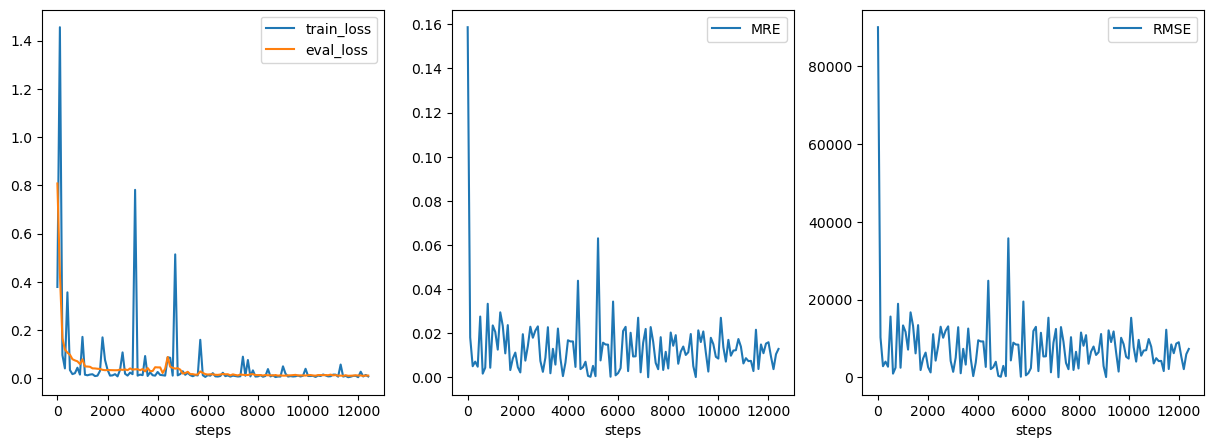

In [48]:
init_model_funcs = {
    ModelType.Transformer.name: init_Transformer_model,
    ModelType.GCNSubgraph.name: init_GCNSubgraph_model,
    ModelType.GRU.name: init_GRU_model,
    ModelType.LSTM.name: init_LSTM_model,
    ModelType.MLPTestSubgraph.name: init_MLPTestSubgraph_model,
}

# model_type = ModelType.MLPTestSubgraph
# model_type = ModelType.LSTM
model_type = ModelType.GRU
init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)

single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)
